# Memory_rate

In [198]:
pip install chromedriver-binary==111.0.5563.64.0

  Preparing metadata (setup.py) ... done
  Created wheel for chromedriver-binary: filename=chromedriver_binary-111.0.5563.64.0-py3-none-any.whl size=8359944 sha256=682a8b0ad2c6d50d5f534f872367cd7da82b2d313a6e627c831c62bc08ca4735
  Stored in directory: /Users/hjm.f/Library/Caches/pip/wheels/50/b8/e8/b2e1b9bb39720081855abca33dae6346309622ced09f0a249c
Successfully built chromedriver-binary
  Attempting uninstall: chromedriver-binary
    Found existing installation: chromedriver-binary 109.0.5414.74.0
    Uninstalling chromedriver-binary-109.0.5414.74.0:
      Successfully uninstalled chromedriver-binary-109.0.5414.74.0
Note: you may need to restart the kernel to use updated packages.


In [13]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")

for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 100000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       hb|   4433941|


# setting warnigs

In [1]:
del jockey_results

NameError: name 'jockey_results' is not defined

# Import

In [6]:
import numpy as np
import pandas as pd
import re
import statistics
import math
from math import sqrt

import datetime
import time
from tqdm.notebook import tqdm

import scipy as sp
from scipy.special import comb
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.integrate import cumtrapz
from scipy import optimize

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from selenium.webdriver import Chrome, ChromeOptions
import chromedriver_binary
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import optuna
import optuna.integration.lightgbm as lgb_o
import lightgbm as lgb
from lightgbm import LGBMClassifier

from tensorflow import keras
from keras import models
from keras import layers
from keras.models import save_model
from keras.models import load_model

import pickle5 as pickle

import pyarrow as pa
import pyarrow.parquet
import pyarrow.csv

import argparse
from collections import defaultdict
from datetime import datetime
from decimal import Decimal
import boto3
from itertools import combinations
from itertools import permutations
from boto3.dynamodb.conditions import Key
import warnings
warnings.resetwarnings()
warnings.simplefilter('ignore')
#warnings.simplefilter('ignore', FutureWarning)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Code

In [7]:
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame() #raw data
        self.data_p = pd.DataFrame() #after preprocessing
        self.data_c = pd.DataFrame() #after processing categorical features
        #self.data_num_rate = pd.DataFrame()
        
    def merge_horse_results(self, hr, n_samples_list=[1,2,3,4,5,6]):
        self.data_p = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_p = hr.merge_all(self.data_p, n_samples=n_samples)
        
        self.data_p['interval'] = (self.data_p['date'] - self.data_p['latest']).dt.days
        self.data_p['interval'] = self.data_p['interval'].map(lambda x: x/30.42 if x>0 else 0)
        self.data_p.drop(['latest'], axis=1, inplace=True)

    def merge_jockey_results(self, jr, n_samples_list=[60,180]):
        self.data_p = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_p = jr.merge_all(self.data_p, n_samples=n_samples)
        #self.data_j.drop(['place'], axis=1, inplace=True)
        
    def merge_trainer_results(self, tr, n_samples_list=[180]):
        self.data_p = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_p = tr.merge_all(self.data_p, n_samples=n_samples)
    
    def process_categorical(self, results_m,st=False):
        df = self.data_p.copy()
        df.drop(['horse_id','jockey_id','trainer_id'], axis=1, inplace=True)

        R_types = results_m['R_type'].unique()
        df['R_type'] = pd.Categorical(df['R_type'], R_types)
        df = pd.get_dummies(df, columns=['R_type'])
        
        df['weather'] = df['weather'].map(weather_dict).fillna('0').astype(int)
        df['sex'] = df['sex'].map(sex_dict).fillna('0').astype(int)
        
        df['spurt_2'] = 2*df['spurt_2R'] - df['spurt_1R']
        df['speed_2'] = 2*df['speed_2R'] - df['speed_1R']
        df['diff_2'] = 2*df['diff_2R'] - df['diff_1R']
        df['runtime_2'] = 2*df['runtime_2R'] - df['runtime_1R']
        df['h_rank/heads_2'] = 2*df['h_rank/heads_2R'] - df['h_rank/heads_1R']
        df['h_rank/heads*grade_2'] = 2*df['h_rank/heads*grade_2R'] - df['h_rank/heads*grade_1R']
        
        df['spurt_3'] = 3*df['spurt_3R'] - df['spurt_1R'] - df['spurt_2']
        df['speed_3'] = 3*df['speed_3R'] - df['speed_1R'] - df['speed_2']
        df['diff_3'] = 3*df['diff_3R'] - df['diff_1R'] - df['diff_2']
        df['runtime_3'] = 3*df['runtime_3R'] - df['runtime_1R'] - df['runtime_2']
        df['h_rank/heads_3'] = 3*df['h_rank/heads_3R'] - df['h_rank/heads_1R'] - df['h_rank/heads_2']
        df['h_rank/heads*grade_3'] = 3*df['h_rank/heads*grade_3R'] - df['h_rank/heads*grade_1R']-df['h_rank/heads*grade_2']
        
        df['course_gap'] = df['course_len']-df['course_len_mean']
        df['R_class'] = df['No.1_sum'].groupby(level=0).mean()
        df['horse_prize_mean'] = df['prize_sum'].groupby(level=0).mean()
        df['prize_gap'] = df['prize_sum'] - df['horse_prize_mean']
        df['class_gap'] = df['No.1_sum'] - df['R_class']
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        df['No.1/days'] = (df['No.1_sum']/df['days'])
        df['No.3/days'] = (df['No.3_sum']/df['days'])
        df['prize/days'] = (df['prize_sum']/df['days'])
        df['jw_rate_60R'] = df['jw_rate_60R'].map(lambda x: math.log(x) if x>0 else 0)
        df['jp_rate_60R'] = df['jp_rate_60R'].map(lambda x: math.log(x) if x>0 else 0)
        #df['tw_rate_60R'] = df['tw_rate_60R'].map(lambda x: math.log(x) if x>0 else 0)
        #df['tp_rate_60R'] = df['tp_rate_60R'].map(lambda x: math.log(x) if x>0 else 0)
        df['place'] = df['place'].astype(int)
        
        def growth_1(x):
            z = 0.004506*x*x*x - 0.1219*x*x + 1.005*x - 1.877
            return z
        def growth_0(x):
            z = 0.009971*x*x*x - 0.2207*x*x + 1.567*x - 2.984
            return z
        def growth_rate_1(x):
            z = 0.013518*x*x - 0.2438*x + 1.005
            return z
        def growth_rate_0(x):
            z = 0.029913*x*x - 0.4414*x + 1.567
            return z

        df1 = df[df['sex']== -1]
        df0 = df[df['sex']!= -1]

        df1['growth'] = growth_1(df1['days'])
        df0['growth'] = growth_0(df0['days'])
        df1['growth_rate'] = growth_rate_1(df1['days'])
        df0['growth_rate'] = growth_rate_0(df0['days'])

        df = pd.concat([df1,df0])
        df = df.loc[:,~df.columns.duplicated()]
        def style_judge(x):
                if x<3: 
                    return 0
                if x>=3:
                    if x<6:
                        return 1
                    if x>=6:
                        if x<9:
                            return 2
                        if x>=9:
                            if x<12:
                                return 3
                            if x>=12:
                                if x<15:
                                    return 4
                                if x>=15:
                                    return 5
                            
        if st==False:
            swr = df[['R_type_芝','place','course_len','1st_corner_3R','rank<3','単勝']].copy()
            
            swr['style'] = swr['1st_corner_3R'].map(lambda x : style_judge(x))
            wins = swr[swr['rank<3']==1]
            swr_count = swr.groupby(['R_type_芝','place','course_len','style'])
            wins_count = wins.groupby(['R_type_芝','place','course_len','style'])
            df_swr = wins_count.count()/swr_count.count()

            df_swr['style_winrate'] = df_swr['単勝']#単勝じゃなくてもいい
            df['style'] = df['1st_corner_3R'].map(lambda x : style_judge(x))
            df = df.join(df_swr['style_winrate'],on=['R_type_芝','place','course_len','style'])
            del swr, wins, swr_count, wins_count,
            df_swr.to_pickle('running_style_winrate.pickle')
        
        if st==True:
            df['style'] = df['1st_corner_3R'].map(lambda x : style_judge(x))
            df_swr = pd.read_pickle('running_style_winrate.pickle')
            df = df.join(df_swr['style_winrate'],on=['R_type_芝','place','course_len','style'])
            
            
        
        self.data_c = df
        
class ShutubaTable(DataProcessor):
    def __init__(self,shutuba_tables):
        super(ShutubaTable,self).__init__()
        self.data = shutuba_tables
    @classmethod
    def scrape(cls,race_id_list):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0,drop=True).T
            
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text,'html.parser')
            
            texts = soup.find('div',attrs={'class':'RaceData01'}).text
            texts = re.findall(r'\w+',texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+',text)[0])] * len(df)
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    df['weather'] = [text] * len(df)
                if text in ['良', '稍重', '重']:
                    df['ground_state'] = [text] * len(df)
                if '不' in text:
                    df['ground_state'] = ['不良'] * len(df)
                if '稍' in text:
                    df['ground_state'] = ['稍重'] * len(df)
                if '芝' in text:
                    df['R_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['R_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['R_type'] = ['ダート'] * len(df)
            

            #df['date'] = [date] * len(df)
            
            horse_id_list = []
            horse_td_list = soup.find_all('td',attrs={'class':'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+',td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            
            jockey_id_list = []
            jockey_td_list = soup.find_all('td',attrs={'class':'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+',td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)

            trainer_id_list = []
            trainer_td_list = soup.find_all('td',attrs={'class':'Trainer'})
            for td in trainer_td_list:
                trainer_id = re.findall(r'\d+',td.find('a')['href'])[0]
                trainer_id_list.append(trainer_id)
            

            df["horse_id"] = horse_id_list
            df['jockey_id'] = jockey_id_list
            df["trainer_id"] = trainer_id_list
            
            df.index = [race_id]*len(df)
            date = soup.find('dd',attrs={'class':'Active'}).text
            df['date'] = df.index.str[:4] + '-'+re.findall(r'\w+',date)[0].replace('月','-').replace('日','')
            #df['date'] = re.findall(r'\d+/\d+',date)[0]
            #df['date'] = df.index.str[:4] +'/'+ df['date']
            data = data.append(df)
            time.sleep(0.1)
            
        return cls(data)
    
    def preprocessing(self,weight=False):
        df = self.data.copy()
        #df['R'] = df.index.str[-2:].astype(int)
        
        df['sex'] = df['性齢'].map(lambda x: str(x)[0])
        #df['age'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)
        df['R'] = df.index.str[-2:].astype(int)
        
        #df.drop(['馬体重(増減)'], axis=1, inplace=True)
        df['jockey_weight'] = df['斤量'].astype(float)
        #1/4馬体重を考慮する
        if weight:
            df = df[df['馬体重(増減)'] != '--']
            df['weight'] = df['馬体重(増減)'].str.split('(', expand=True)[0].astype(float)
            df['++weight'] = df['馬体重(増減)'].str.split('(', expand=True)[1].str[:-1].replace('前計不',0).astype(float)
            df['weight_per'] = df['jockey_weight']/df['weight']
        
        df['date'] = pd.to_datetime(df['date'])
        df['waku'] = df['枠'].astype(int)
        df['number'] = df['馬番'].astype(int)
        df['course_len'] = df['course_len'].astype(float)
        df['place'] = df['開催'] = df.index.map(lambda x: str(x)[4:6]).astype(int)
        df['n_horses'] = df.index.map(df.index.value_counts())
        df['month'] = df['date'].dt.month
        df['weather'] = df['weather'].map(weather_dict).fillna('0').astype(int)
        df['sex'] = df['sex'].map(sex_dict).fillna('0').astype(int)
        df['ground'] = df['ground_state'].str.extract(r'(\D+)')[0].map(ground_dict).fillna('5')
        df['ground'] = df['ground'].astype(int)
        df = df[df['ground']!=5]
        df.drop(['ground_state'], axis=1, inplace=True) 
        df['m/kg'] = df['course_len'] /df['jockey_weight']
        
        if weight==False:
            df = df[['course_len','m/kg','date','R','number','waku','jockey_weight','place','month','n_horses','weather','R_type','ground','horse_id','jockey_id','trainer_id','sex',]]
        
        #2/4馬体重を考慮する
        if weight:
            df = df[['course_len','m/kg','date','R','weight','++weight','number','waku','jockey_weight','weight_per','place','month','n_horses','weather','R_type','ground','horse_id','jockey_id','trainer_id','sex',]]
        
        self.data_p = df
        waku_winrate = pd.read_pickle('waku_winrate.pickle')
        df_join = df.join(waku_winrate['waku_winrate'],on=['place','R_type','course_len','waku'])
        #df_join = df.join(r.data_num_rate['waku_winrate'],on=['place','R_type','course_len','waku'])
        self.data_p = df_join
        
        self.data_p = pd.merge(self.data_p,hb,left_on='horse_id',right_index=True)
        self.data_p['days'] = (self.data_p['date']-self.data_p['birth']).dt.days/365
        
        course_infos = pd.read_excel('course_infos.xlsx')
        self.data_p_merge = self.data_p.merge(course_infos,on=['place','R_type','course_len'],how='left')
        self.data_p_merge.index=self.data_p.index
        self.data_p_merge['last_slope'] = self.data_p_merge['last_ΔH']/self.data_p_merge['last_ΔL']*100
        self.data_p_merge['first_slope'] = self.data_p_merge['first_ΔH']/self.data_p_merge['first_ΔL']*100
        self.data_p = self.data_p_merge.copy()
        
        
        del df_join,self.data_p_merge
                
class Results(DataProcessor):
    def __init__(self,results):
        super(Results,self).__init__()
        self.data = results
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
        
    def preprocessing(self, year, R, weight=False):
        df = self.data.copy()
        
        df['R'] = df.index.str[-2:].astype(int)
        df['着順'] = pd.to_numeric(df['着順'],errors='coerce')
        df.dropna(subset=['着順'],inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank=1'] = df['着順'].map(lambda x:1 if  x==1 else 0)
        df['rank<2'] = df['着順'].map(lambda x:1 if  x<3 else 0)
        df['rank<3'] = df['着順'].map(lambda x:1 if  x<4 else 0)
        df['rank<5'] = df['着順'].map(lambda x:1 if  x<6 else 0)
        df['rank<8'] = df['着順'].map(lambda x:1 if  x<9 else 0)
        df['sex'] = df['性齢'].map(lambda x: str(x)[0])        
        df['number'] = df['馬番'].astype(int)
        df['waku'] = df['枠番'].astype(int)
        df['jockey_weight'] = df['斤量'].astype(int)
        df['R_type'] = df['race_type']
        
        #3/4馬体重を考慮する
        if weight:
            df['weight'] = df['馬体重'].str.split("(", expand=True)[0].astype(float)
            df['++weight'] = df['馬体重'].str.split("(", expand=True)[1].str[:-1].astype(float)
            df['weight_per'] = df['jockey_weight']/df['weight']
        
        df['単勝'] = df['単勝'].astype(float)
        df['course_len'] = df['course_len'].map(lambda x: 2000.0 if x<3 else x)
        df['course_len'] = df['course_len'].astype(float)
        df['m/kg'] = df['course_len'] /df['jockey_weight']
        df['place'] = df.index.map(lambda x: str(x)[4:6]).astype(int)
        df['date'] = pd.to_datetime(df['date'], format="%Y年%m月%d日")
        df['month'] = df['date'].dt.month
        df['n_horses'] = df.index.map(df.index.value_counts())
        df['ground'] = df['ground_state'].str.extract(r'(\D+)')[0].map(ground_dict).fillna('5')
        df['ground'] = df['ground'].astype(int)
        df = df[df['ground']!=5]
        
        ###除外対象
        df = df[df['jockey_id']!='00815']
        df = df[df['jockey_id']!='05074']
        df = df[df['jockey_id']!='05455']
        df = df[df['jockey_id']!='05396']
        df = df[df['jockey_id']!='05294']
        df = df[df['jockey_id']!='05490']
        df = df[df['trainer_id']!='05235']
        df = df[df['trainer_id']!='05390']
        df = df[df['trainer_id']!='05160']
        df = df[df['trainer_id']!='05681']
        ###
        
        df.drop(['枠番','馬番','斤量','タイム', '着差', '調教師', '性齢','馬名','騎手','馬体重', '人気','owner_id','ground_state','race_type'], axis=1, inplace=True)
        
        self.data_p = df
        self.data_p_rank = df[df['rank<3']==1]
        self.data_p_ = self.data_p[['place','course_len','R_type','着順','waku']]
        self.data_p_rank = self.data_p_rank[['place','course_len','R_type','着順','waku']]
        self.data_p_grp = self.data_p_.groupby(['place','R_type','course_len','waku'])
        self.data_p_rank_grp = self.data_p_rank.groupby(['place','R_type','course_len','waku'])
        self.data_num_rate = self.data_p_rank_grp.count()/self.data_p_grp.count()
        self.data_num_rate['waku_winrate'] = self.data_num_rate['着順'].map(lambda x: 0.5 if x>0.5 else x)
        self.data_num_rate.to_pickle('waku_winrate.pickle')
        waku_winrate = pd.read_pickle('waku_winrate.pickle')
        df_join = df.join(waku_winrate['waku_winrate'],on=['place','R_type','course_len','waku'])
        
        df_join.drop(['着順'], axis=1, inplace=True)
        self.data_p = df_join
        self.data_p['date'] = pd.to_datetime(self.data_p['date'], format="%Y年%m月%d日")
        self.data_p = self.data_p[self.data_p['R_type']!='障害']
        self.data_p = pd.merge(self.data_p,hb,left_on='horse_id',right_index=True)
        self.data_p['days'] = (self.data_p['date']-self.data_p['birth']).dt.days/365
        self.data_p = self.data_p[self.data_p['R'] > R]
        self.data_p = self.data_p[self.data_p['date'] > year]
        
        course_infos = pd.read_excel('course_infos.xlsx')
        self.data_p_merge = self.data_p.merge(course_infos,on=['place','R_type','course_len'],how='left')
        self.data_p_merge.index=self.data_p.index
        self.data_p_merge['last_slope'] = self.data_p_merge['last_ΔH']/self.data_p_merge['last_ΔL']*100
        self.data_p_merge['first_slope'] = self.data_p_merge['first_ΔH']/self.data_p_merge['first_ΔL']*100
        self.data_p = self.data_p_merge.copy()
        
        del df_join, self.data_p_, self.data_p_rank, self.data_p_rank_grp, self.data_p_grp,self.data_p_merge

    def process_categorical(self):
        #self.le_horse = LabelEncoder().fit(self.data_p['horse_id'])
        #self.le_jockey = LabelEncoder().fit(self.data_p['jockey_id'])
        #self.le_trainer = LabelEncoder().fit(self.data_p['trainer_id'])
        #super().process_categorical(self.le_horse,self.le_jockey,self.le_trainer,self.data_p)
        super().process_categorical(self.data_p)

class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付','開催','R','レース名','頭数','オッズ','着順','斤量','距離','馬場','馬場指数','タイム','着差','ﾀｲﾑ指数','通過','ペース','上り','賞金','備考','x','y',]]#'人気',
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    def preprocessing(self):
        df = self.horse_results.copy()
        df = df.loc[:,~df.columns.duplicated()]
        df.index.name = 'horse_id'
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res

        def Deviation_val(x):
            val = ((x - x.mean())/x.std())*1+10
            return val
        
        #コーナーへの進入順位をintに変換
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])

        def www(x,n):
            return int(re.findall(r'\d+', x)[0])

        #R_grade
        df1 = df['レース名']
        df0 = df1.astype(str).map(lambda x: 1.00 if '新馬' in x else x )
        df1 = df0.astype(str).map(lambda x: 1.00 if '未勝利' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.97 if '500万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.88 if '1000万下' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.53 if '1600万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.97 if '1勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.88 if '2勝クラス' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.53 if '3勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.36 if 'OP' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'L' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.23 if 'G3' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.12 if 'G2' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.08 if 'G1' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'G' in x else x )
        df['R_grade'] = pd.to_numeric(df1, errors='coerce')
        df.dropna(subset=['R_grade'], inplace=True)
        df['R_grade'] = 1/df['R_grade']
        
        #cols_to_numeric = ['頭数','馬場指数','着順','距離','','',]

        #place
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        df['place'] = df['place'].astype(int)
        df = df[df['place']!=11]

        #R_type[芝orダor障]を作成し、[障]を除外
        df['R_type'] = df['距離'].str.extract(r'(\D+)')[0].map(R_type_dict)

        #date
        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)

        #R
        df['R'] = df['R']
        df.dropna(subset=['R'], inplace=True)

        #heads
        df['頭数'] = pd.to_numeric(df['頭数'], errors='coerce')
        df.dropna(subset=['頭数'], inplace=True)
        df['heads'] = df['頭数'].astype(int)

        #ground
        df['馬場指数'] = pd.to_numeric(df['馬場指数'], errors='coerce')
        df.dropna(subset=['馬場指数'], inplace=True)#subsetでdrop対象の列を指定
        df['ground'] = df['馬場指数'].astype(float)

        #course_len
        df['距離'] = df['距離'].map(lambda x: www(x,1))
        df['距離'] = pd.to_numeric(df['距離'], errors='coerce')
        df.dropna(subset=['距離'], inplace=True)
        df['course_len'] = df['距離'].astype(int)

        #kg
        df.dropna(subset=['斤量'], inplace=True)
        df['kg'] = df['斤量']

        #course_len * kg
        df['len*kg'] = df['course_len']*df['kg']/10

        #h_rank
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)#subsetでdrop対象の列を指定
        df['h_rank'] = df['着順'].astype(int)

        #No.1 No.3 n_entry
        df['No.1'] = df['h_rank'].map(lambda x: 1 if x<2 else 0)
        df['No.3'] = df['h_rank'].map(lambda x: 1 if x<4 else 0)
        df['n_entry'] = df['h_rank'].map(lambda x: 1 if x<20 else 0)

        #1st_3F
        df['1st_3F'] = df['ペース'].str.split('-', expand=True)[0].astype(float)
        df['1st_3F'] = df['1st_3F'].map(lambda x:x if x>1 else 35)
        df['1st_3F'] = 600/df['1st_3F']
        df['1st_3F'] = df.groupby(['place','R_type','course_len','馬場'])['1st_3F'].transform(scale)

        #last_3F
        df['last_3F'] = df['ペース'].str.split('-', expand=True)[1].astype(float)
        df['last_3F'] = 600/df['last_3F']


        df['pace'] =  df['last_3F']/df['1st_3F']
        df['pace'] = df.groupby(['place','R_type','course_len','馬場'])['pace'].transform(scale)

        df['h_rank/heads'] = df['heads']/df['h_rank']
        df['h_rank/heads*grade'] = df['h_rank/heads']*df['R_grade']

        #rank / kg
        df['rank/kg'] = df['kg']/df['h_rank/heads']

        df['1st_corner'] = df['通過'].map(lambda x: corner(x,1))
        df['last_corner'] = df['通過'].map(lambda x: corner(x,4))
        df['1st-rank']  = df['1st_corner']  - df['h_rank']
        df['last-rank'] = df['last_corner'] - df['h_rank']
        df['1st-last']  = df['last_corner'] - df['1st_corner']

        #prize
        df['賞金'].fillna(0, inplace=True)
        df['prize'] = df['賞金'].map(lambda x: math.log10(x) if x>0 else 0)

        #diff
        df['着差'] = pd.to_numeric(df['着差'], errors='coerce')
        df.dropna(subset=['着差'], inplace=True)
        df['diff'] = df['着差']

        df['position_4C'] = df['y']*-2.4
        df['position_Goal'] = df['diff']*df['last_3F']
        df['rush'] = df['position_4C'] - df['position_Goal']

        df['last_3F'] = df.groupby(['place','R_type','course_len','馬場'])['last_3F'].transform(scale)
        df['diff'] = df.groupby(['place','R_type','course_len','馬場'])['diff'].transform(scale)*-1

        #ozz
        #df['オッズ'] = pd.to_numeric(df['オッズ'], errors='coerce')
        #df.dropna(subset=['上り'], inplace=True)
        #df = df[df['オッズ']!=0]
        #df['ozz'] = df['オッズ'].astype(float)
        #df['ozz'] = (1/df['ozz']).map(lambda x: math.log10(x) if x>0 else 0)
        #df['ozz'] = (df['ozz'] - df['ozz'].min())/(df['ozz'].max()-df['ozz'].min())

        #spurt
        df['上り'] = pd.to_numeric(df['上り'], errors='coerce')
        df.dropna(subset=['上り'], inplace=True)
        df['spurt'] = df['上り'].astype(float)
        df['spurt'] = 600/df['spurt']
        df['spurt'] = df['spurt'].map(lambda x: 13 if x<13 else x)
        df['spurt']  = df.groupby(['place','R_type','course_len','馬場'])['spurt'].transform(scale)

        #speed
        time = df['タイム']
        time = time.str.split(':', expand=True)
        for n in range(0,2):
            time[n] = pd.to_numeric(time[n], errors='coerce')
        df['time'] = time[0]*60 + time[1]
        df['speed'] = df['course_len']/df['time']
        df['speed'] = df['speed'].map(lambda x: 15 if x<15 else x)
        df['speed']  = df.groupby(['place','R_type','course_len','馬場'])['speed'].transform(scale)

        #runtime
        df['ﾀｲﾑ指数'] = pd.to_numeric(df['ﾀｲﾑ指数'], errors='coerce')
        df.dropna(subset=['ﾀｲﾑ指数'], inplace=True)#subsetでdrop対象の列を指定
        df['runtime'] = df['ﾀｲﾑ指数'].astype(float)
        df['runtime'] = df['runtime'].map(lambda x: 0 if x<0 else x)

        #R_level
        df['R_level'] = df['runtime']
        gr = df.groupby(['date','place','R'])['R_level'].quantile(0.25)
        df.drop(['R_level'], axis=1, inplace=True)
        df = df.merge(gr, left_on=['date','place','R'], right_index=True, how='left')
        del gr
        #df['R_level'] = (df['R_level'] - df['R_level'].min())/(df['R_level'].max()-df['R_level'].min())+0.05

        #R_level/rank
        df['rank/level'] = df['R_level']*df['h_rank/heads']

        df['late'] = df['備考'].astype(str).map(lambda x: 1 if '出遅れ' in x else 0 )

        cols_single = ['R_grade','ground','kg','len*kg','1st_3F','last_3F','pace','prize','diff','spurt','time','speed','runtime','R_level','rank/level','rank/kg','h_rank/heads*grade','position_4C','rush']#'ozz',
        for col in cols_single:
            df[col] = Deviation_val(df[col])

        df['speed*1st_3F'] = (df['speed']*df['1st_3F'])**0.5
        df['speed*last_3F'] = (df['speed']*df['last_3F'])**0.5
        df['speed*pace'] = (df['speed']*df['pace'])**0.5
        df['spurt*1st_3F'] = (df['spurt']/df['1st_3F'])
        df['spurt*last_3F'] = (df['spurt']/df['last_3F'])
        df['spurt*pace'] = (df['spurt']*df['pace'])**0.5
        df['spurt_Lv1'] = (df['spurt']-df['1st_3F'])
        df['spurt_Lv2'] = (df['spurt'] -df['last_3F'])
        df['diff*level'] = (df['diff']*df['R_level'])**0.5
        df['spurt*level'] = (df['spurt']*df['R_level'])**0.5
        df['speed*level'] = (df['speed']*df['R_level'])**0.5
        df['runtime*level'] = (df['runtime']*df['R_level'])**0.5
        df['diff*kg'] = (df['diff']*df['kg'])**0.5
        df['spurt*kg'] = (df['spurt']*df['kg'])**0.5
        df['speed*kg'] = (df['speed']*df['kg'])**0.5
        df['runtime*kg'] = (df['runtime']*df['kg'])**0.5
        df['runtime*spurt'] = (df['runtime']*df['spurt'])**0.5
        df['runtime*speed'] = (df['runtime']*df['speed'])**0.5
        df['runtime*diff'] = (df['runtime']*df['diff'])**0.5
        df['spurt*speed'] = (df['spurt']*df['speed'])**0.5
        df['spurt*diff'] = (df['spurt']*df['diff'])**0.5
        df['speed*diff'] = (df['speed']*df['diff'])**0.5

        df['rush*runtime'] = (df['rush']*df['runtime'])**0.5
        df['rush*spurt'] = (df['rush']*df['spurt'])**0.5
        df['rush*speed'] = (df['rush']*df['speed'])**0.5
        df['rush*diff'] = (df['rush']*df['diff'])**0.5

        df['position*runtime'] = (df['position_4C']*df['runtime'])**0.5
        df['position*spurt'] = (df['position_4C']*df['spurt'])**0.5
        df['position*speed'] = (df['position_4C']*df['speed'])**0.5
        df['position*diff'] = (df['position_4C']*df['diff'])**0.5

        #df['diff*ozz'] = (df['diff']*df['ozz'])**0.5
        #df['runtime*ozz'] = (df['runtime']*df['ozz'])**0.5
        #df['spurt*ozz'] = (df['spurt']*df['ozz'])**0.5
        #df['speed*ozz'] = (df['speed']*df['ozz'])**0.5

        cols_double = ['speed*1st_3F','speed*last_3F','speed*pace','spurt*1st_3F','spurt*last_3F','spurt*pace','spurt_Lv1','spurt_Lv2','diff*level','spurt*level','speed*level','runtime*level','spurt*kg','speed*kg','runtime*kg',\
                        'runtime*spurt','runtime*speed','runtime*diff','spurt*speed','spurt*diff','speed*diff','rush*runtime','rush*speed','rush*spurt','rush*diff','position*runtime','position*speed','position*spurt','position*diff']#'diff*ozz','runtime*ozz','spurt*ozz','speed*ozz'
        for col in cols_double:
            df[col] = Deviation_val(df[col])
            
        self.horse_results = df
        
        self.target_list      = ['R_grade','R_level','len*kg', 'h_rank', 'late',\
                                 '1st_3F', 'last_3F', 'pace', 'h_rank/heads', 'h_rank/heads*grade','rank/kg', '1st_corner', 'last_corner', '1st-rank', 'last-rank','1st-last',\
                                 'prize', 'diff',  'spurt', 'time', 'speed', 'runtime','position_4C','rush',\
                                 'rank/level', 'speed*1st_3F', 'speed*last_3F','speed*pace','spurt*1st_3F', 'spurt*last_3F','spurt*pace', 'spurt_Lv1', 'spurt_Lv2', 'diff*level', 'spurt*level','speed*level', 'runtime*level', \
                                 'runtime*spurt','runtime*speed','spurt*speed','spurt*diff','speed*diff','runtime*diff','rush*runtime','rush*speed','rush*spurt','rush*diff','position*runtime','position*speed','position*spurt','position*diff']#'ozz''runtime*ozz','speed*ozz','spurt*ozz','diff*ozz',
        
        self.target_list_sum  = ['pace','prize','No.1','No.3','n_entry','late']
        
        self.target_list_max  = ['1st_3F', 'last_3F', 'pace', 'h_rank/heads', 'h_rank/heads*grade','rank/kg',\
                                 'prize', 'diff',  'spurt', 'time', 'speed', 'runtime','position_4C','rush',\
                                 'rank/level', 'speed*1st_3F', 'speed*last_3F','speed*pace','spurt*1st_3F', 'spurt*last_3F','spurt*pace', 'spurt_Lv1', 'spurt_Lv2', 'diff*level', 'spurt*level','speed*level', 'runtime*level', \
                                 'runtime*spurt','runtime*speed','spurt*speed','spurt*diff','speed*diff','runtime*diff','rush*runtime','rush*speed','rush*spurt','rush*diff','position*runtime','position*speed','position*spurt','position*diff']#'ozz''runtime*ozz','speed*ozz','spurt*ozz','diff*ozz',
        
        self.target_list_min  = []
        
        self.target_list_mean = ['R_grade','R_level','len*kg', 'h_rank', 'course_len',\
                                 '1st_3F', 'last_3F', 'pace', 'h_rank/heads', 'h_rank/heads*grade','rank/kg', '1st_corner', 'last_corner', '1st-rank', 'last-rank','1st-last',\
                                 'prize', 'diff', 'spurt', 'time', 'speed', 'runtime','position_4C','rush',\
                                 'rank/level', 'late', 'speed*1st_3F', 'speed*last_3F','spurt*1st_3F', 'spurt*last_3F', 'speed*pace','spurt*pace', 'spurt_Lv1', 'spurt_Lv2', 'diff*level', 'spurt*level','speed*level', 'runtime*level',\
                                 'runtime*spurt','runtime*speed','spurt*speed','spurt*diff','speed*diff','runtime*diff','rush*runtime','rush*speed','rush*spurt','rush*diff','position*runtime','position*speed','position*spurt','position*diff']#'ozz''runtime*ozz','speed*ozz','spurt*ozz','diff*ozz',
        
        self.target_list_std  = ['h_rank/heads', 'h_rank/heads*grade','rank/kg','1st_corner', 'last_corner','1st-last','prize', 'diff', 'spurt', 'time', 'speed', 'runtime','position_4C','rush']
        

    def at_class(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        
        date_last_1st = filtered_df[filtered_df['着順']==1][['date']].groupby(level=0).head(1)
        date_last_1st = date_last_1st.rename(columns={'date': 'date2'})
        filtered_df = pd.merge(filtered_df, date_last_1st, right_index=True, left_index=True, how='left')
        filtered_df['date2'].fillna(pd.to_datetime('2011-12-31 00:00:00'), inplace=True)
        filtered_df = filtered_df[filtered_df['date'] > filtered_df['date2']]
        filtered_df = filtered_df[filtered_df['place']!=11]
        class_ = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_class')
        return class_
    
    def at_max(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        max_ = filtered_df.groupby(level=0)[self.target_list_max].max().add_suffix('_max')
        return max_
    
    def at_min(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        min_ = filtered_df.groupby(level=0)[self.target_list_min].min().add_suffix('_min')
        return min_

    def at_sum(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        sum_ = filtered_df.groupby(level=0)[self.target_list_sum].sum().add_suffix('_sum')
        return sum_
    
    def at_mean(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        mean_ = filtered_df.groupby(level=0)[self.target_list_mean].mean().add_suffix('_mean')
        return mean_

    def at_std(self, horse_id_list, date):
        target_df = self.horse_results.loc[horse_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        std_ = filtered_df.groupby(level=0)[self.target_list_std].std().add_suffix('_std')
        return std_
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')

        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))
            
        if n_samples == 1:
            self.latest = filtered_df.groupby('horse_id')['date'].max().rename('latest')

    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id', right_index=True, how='left')
                    
        if n_samples == 1:
            merged_df = merged_df.merge(self.at_class(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_max(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_min(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_sum(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_mean(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.at_std(horse_id_list, date), left_on='horse_id', right_index=True, how='left')
            merged_df = merged_df.merge(self.latest, left_on='horse_id',right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

class JockeyResults:
    def __init__(self, jockey_results):
        self.jockey_results = jockey_results[['日付','開催','R','レース名','頭数','単勝','着順','距離','馬場','着差','通過','賞金(万円)']]
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    def preprocessing(self):
        df = self.jockey_results.copy()
        df = df.loc[:,~df.columns.duplicated()]
        
        df1 = df['レース名']
        df0 = df1.astype(str).map(lambda x: 1.00 if '新馬' in x else x )
        df1 = df0.astype(str).map(lambda x: 1.00 if '未勝利' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.97 if '500万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.88 if '1000万下' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.53 if '1600万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.97 if '1勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.88 if '2勝クラス' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.53 if '3勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.36 if 'OP' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'L' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.23 if 'G3' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.12 if 'G2' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.08 if 'G1' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'G' in x else x )
        
        df['race_grade'] = pd.to_numeric(df0, errors='coerce')
        df.dropna(subset=['race_grade'], inplace=True)
        df['race_grade'] = 1/df['race_grade']
        
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        df['place'] = df['place'].astype(int)
        df = df[df['place']!=11]
        
        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        df['R_type'] = df['距離'].str.extract(r'(\D+)')[0].map(R_type_dict)
        
        df['course_len'] = df['距離'].str.extract(r'(\d+)')
        df['course_len'] = pd.to_numeric(df['course_len'], errors='coerce')
        df.drop(['距離'], axis=1, inplace=True)
        
        df['賞金(万円)'] = pd.to_numeric(df['賞金(万円)'], errors='coerce')
        df['賞金(万円)'] = df['賞金(万円)'].fillna(0)
        df['j_prize'] = df['賞金(万円)'].astype(int).map(lambda x: math.log10(x) if x>0 else 0)
        df.drop(['賞金(万円)'], axis=1, inplace=True)
        
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['j_rank'] = df['着順'].astype(int)
        df.drop(['着順'], axis=1, inplace=True)
        
        df['頭数'] = pd.to_numeric(df['頭数'], errors='coerce')
        df.dropna(subset=['頭数'], inplace=True)
        df['heads'] = df['頭数'].astype(int)
        
        df['着差'] = pd.to_numeric(df['着差'], errors='coerce')
        df.dropna(subset=['着差'], inplace=True)
        df['j_diff'] = -df['着差'].map(lambda x: 10 if x>10 else x)
        df['j_diff'] = (df['j_diff'] - df['j_diff'].min())/(df['j_diff'].max()-df['j_diff'].min())
        
        df['単勝'] = pd.to_numeric(df['単勝'], errors='coerce')
        df.dropna(subset=['単勝'], inplace=True)
        df = df[df['単勝']!=0]
        df['j_ozz'] = df['単勝'].astype(float)
        df['j_ozz'] = (1/df['j_ozz'])#.map(lambda x: math.log10(x) if x>0 else 0)
        df['j_ozz'] = (df['j_ozz'] - df['j_ozz'].min())/(df['j_ozz'].max()-df['j_ozz'].min())
        
        df['j_diff*ozz'] = df['j_diff']*df['j_ozz']
        
        df['j_rank/heads'] = df['j_rank']/df['heads']
        df['j_rank/heads/grade'] = df['j_rank/heads']/df['race_grade']
        df['j_rank/grade'] = df['j_rank']/df['race_grade']
        
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['j_1st_corner'] = df['通過'].map(lambda x: corner(x,1))
        df['j_last_corner'] = df['通過'].map(lambda x: corner(x,4))
        df['j_1st-rank']  = df['j_1st_corner']  - df['j_rank']
        df['j_last-rank'] = df['j_last_corner'] - df['j_rank']
        df['j_1st-last'] = df['j_last_corner'] - df['j_1st_corner']
        
        df['jw_rate'] = df['j_rank'].map(lambda x: 1 if x<2 else 0)
        df['jp_rate'] = df['j_rank'].map(lambda x: 1 if x<4 else 0)
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        df['j_diff'] = df.groupby(['R_type','place'])['j_diff'].transform(scale)
        
        zscore = lambda x: (x - x.mean()) / x.std()
        df[['j_rank/heads','j_rank/heads/grade','j_rank/grade','j_prize','j_diff','j_diff*ozz']] = df[['j_rank/heads','j_rank/heads/grade','j_rank/grade','j_prize','j_diff','j_diff*ozz']]

        self.jockey_results = df
        self.target_list      = ['j_rank/heads','j_rank/heads/grade','j_rank/grade','j_prize','j_diff','j_diff*ozz','jw_rate','jp_rate']
        self.target_list_mean = ['j_prize','j_diff','j_diff*ozz','j_rank/heads','j_rank/heads/grade','j_rank/grade','jw_rate','jp_rate','j_1st_corner','j_1st-rank','j_1st-last']
    
    def at_mean(self, jockey_id_list, date):
        target_df = self.jockey_results.loc[jockey_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        mean_ = filtered_df.groupby(['jockey_id','R_type','place'])[self.target_list_mean].mean().add_suffix('_mean')
        return mean_
    
    def average(self, jockey_id_list, date, n_samples='all'):
        target_df = self.jockey_results.query('index in @jockey_id_list')

        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))
        

    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        jockey_id_list = df['jockey_id']
        self.average(jockey_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='jockey_id', right_index=True, how='left')
        if n_samples == 120:
            merged_df = merged_df.merge(self.at_mean(jockey_id_list, date), left_on=['jockey_id','R_type','place'],right_index=True,how='left')
        
        return merged_df
    
    # r.data_h から取り出した date を元に
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

class TrainerResults:
    def __init__(self, trainer_results):
        self.trainer_results = trainer_results[['日付','開催','R','レース名','頭数','単勝','着順','距離','馬場','着差','通過','賞金(万円)']]
        self.preprocessing()
       
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    def preprocessing(self):
        df = self.trainer_results.copy()
        df = df.loc[:,~df.columns.duplicated()]
        
        df1 = df['レース名']
        df0 = df1.astype(str).map(lambda x: 1.00 if '新馬' in x else x )
        df1 = df0.astype(str).map(lambda x: 1.00 if '未勝利' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.97 if '500万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.88 if '1000万下' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.53 if '1600万下' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.97 if '1勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.88 if '2勝クラス' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.53 if '3勝クラス' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.36 if 'OP' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'L' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.23 if 'G3' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.12 if 'G2' in x else x )
        df0 = df1.astype(str).map(lambda x: 0.08 if 'G1' in x else x )
        df1 = df0.astype(str).map(lambda x: 0.30 if 'G' in x else x )

        df['race_grade'] = pd.to_numeric(df1, errors='coerce')
        df.dropna(subset=['race_grade'], inplace=True)
        df['race_grade'] = 1/df['race_grade']
        
        df['place'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        df['place'] = df['place'].astype(int)
        df = df[df['place']!=11]
        
        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        df['R_type'] = df['距離'].str.extract(r'(\D+)')[0].map(R_type_dict)
        
        df['course_len'] = df['距離'].str.extract(r'(\d+)')
        df['course_len'] = pd.to_numeric(df['course_len'], errors='coerce')
        df.drop(['距離'], axis=1, inplace=True)
        
        df['賞金(万円)'] = pd.to_numeric(df['賞金(万円)'], errors='coerce')
        df['賞金(万円)'] = df['賞金(万円)'].fillna(0)
        df['t_prize'] = df['賞金(万円)'].astype(int).map(lambda x: math.log10(x) if x>0 else 0)
        df.drop(['賞金(万円)'], axis=1, inplace=True)
        
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['t_rank'] = df['着順'].astype(int)
        df.drop(['着順'], axis=1, inplace=True)
        
        df['頭数'] = pd.to_numeric(df['頭数'], errors='coerce')
        df.dropna(subset=['頭数'], inplace=True)
        df['heads'] = df['頭数'].astype(int)
        
        df['単勝'] = pd.to_numeric(df['単勝'], errors='coerce')
        df.dropna(subset=['単勝'], inplace=True)
        df['t_ozz'] = df['単勝'].astype(float)
        df['1/t_ozz'] = 1/df['t_ozz']
        
        df['着差'] = pd.to_numeric(df['着差'], errors='coerce')
        df.dropna(subset=['着差'], inplace=True)
        df['t_diff'] = df['着差'].map(lambda x: 0 if x<0 else x)
        df['t_diff'] = -1*df['t_diff'].map(lambda x: math.log(x) if x>0 else 0)
        
        df['t_rank/heads'] = df['t_rank']/df['heads']
        df['t_rank/heads/grade'] = df['t_rank/heads']/df['race_grade']
        df['t_rank/grade'] = df['t_rank']/df['race_grade']
        
        def corner(x,n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['t_1st_corner'] = df['通過'].map(lambda x: corner(x,1))
        df['t_last_corner'] = df['通過'].map(lambda x: corner(x,4))
        
        df['t_1st-rank']  = df['t_1st_corner']  - df['t_rank']
        df['t_last-rank'] = df['t_last_corner'] - df['t_rank']
        
        df['tw_rate'] = df['t_rank'].map(lambda x: 1 if x<2 else 0)
        df['tp_rate'] = df['t_rank'].map(lambda x: 1 if x<4 else 0)
        
        def scale(x):
            res = (x - np.mean(x)) / np.std(x, ddof=1)
            return res
        df['t_diff'] = df.groupby(['R_type','place'])['t_diff'].transform(scale)
        
        zscore = lambda x: (x - x.mean()) / x.std()
        df[['t_rank/heads','t_rank/heads/grade','t_rank/grade','t_prize','t_diff']] =  df[['t_rank/heads','t_rank/heads/grade','t_rank/grade','t_prize','t_diff']].transform(zscore)

        self.trainer_results = df
        self.target_list = ['t_rank/heads','t_rank/heads/grade','t_rank/grade','t_prize','t_diff','tw_rate','tp_rate']
        self.target_list_mean = ['t_prize','t_diff','t_rank/heads','t_rank/heads/grade','t_rank/grade','tw_rate','tp_rate']
        
    def at_mean(self, trainer_id_list, date):
        target_df = self.trainer_results.loc[trainer_id_list]
        filtered_df = target_df[target_df['date'] < date]
        filtered_df = filtered_df[filtered_df['place']!=11]
        mean_ = filtered_df.groupby(['trainer_id','R_type','place'])[self.target_list_mean].mean().add_suffix('_mean')
        return mean_
    
    def average(self, trainer_id_list, date, n_samples='all'):
        target_df = self.trainer_results.query('index in @trainer_id_list')

        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))

    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        trainer_id_list = df['trainer_id']
        self.average(trainer_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='trainer_id', right_index=True, how='left')
        
        if n_samples == 120:
            merged_df = merged_df.merge(self.at_mean(trainer_id_list, date), left_on=['trainer_id','R_type','place'],right_index=True,how='left')
        return merged_df
    
    # r.data_h から取り出した date を元に
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1,2,3]]
        tansho.columns = ['win', 'return','ninki']
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return tansho
    
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]]
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
        return df.fillna(0).astype(int)
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0]=='馬連'][[1,2]]
        wins = umaren[1].str.split('-', expand=True)[[0,1]].add_prefix('win_')
        return_ = umaren[2].rename('return')  
        df = pd.concat([wins, return_], axis=1)        
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def umatan(self):
        umatan = self.return_tables[self.return_tables[0]=='馬単'][[1,2]]
        wins = umatan[1].str.split('→', expand=True)[[0,1]].add_prefix('win_')
        return_ = umatan[2].rename('return')  
        df = pd.concat([wins, return_], axis=1)        
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def wide(self):
        wide = self.return_tables[self.return_tables[0]=='ワイド'][[1,2]]
        wins = wide[1].str.split('br', expand=True)[[0,1,2]]
        wins = wins.stack().str.split('-', expand=True).add_prefix('win_')
        return_ = wide[2].str.split('br', expand=True)[[0,1,2]]
        return_ = return_.stack().rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce'))
    
    @property
    def sanrentan(self):
        rentan = self.return_tables[self.return_tables[0]=='三連単'][[1,2]]
        wins = rentan[1].str.split('→', expand=True)[[0,1,2]].add_prefix('win_')
        return_ = rentan[2].rename('return')
        df = pd.concat([wins, return_], axis=1) 
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def sanrenpuku(self):
        renpuku = self.return_tables[self.return_tables[0]=='三連複'][[1,2]]
        wins = renpuku[1].str.split('-', expand=True)[[0,1,2]].add_prefix('win_')
        return_ = renpuku[2].rename('return')
        df = pd.concat([wins, return_], axis=1) 
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

class ModelEvaluator:
    def __init__(self, model, return_tables_path_list):
        self.model = model
        self.rt = Return.read_pickle(return_tables_path_list)
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.umatan = self.rt.umatan
        self.wide = self.rt.wide
        self.sanrentan = self.rt.sanrentan
        self.sanrenpuku = self.rt.sanrenpuku
        
    #３着以内に入る馬を予想している
    def predict_proba(self, X, shutuba=False, dl=False, std=True, minmax=False):
        if shutuba:
            proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        else:
            if dl:
                X = X.drop(['単勝'], axis=1)
                X_dl = np.array(X.values)
                X_st = scaler.fit_transform(X_dl)
                proba = pd.Series(self.model.predict(X_st))
            else:
                proba = pd.Series(self.model.predict_proba(X.drop(['単勝'], axis=1))[:, 1], index=X.index)
        
        if std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
        if minmax:
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    #0or1を予想している
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        self.proba = y_pred
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features": X.columns,"importance": self.model.feature_importances_})
        return importances.sort_values("importance", ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['number', '単勝']]
        pred_table['pred'] = self.predict(X, threshold)
        pred_table['score'] = self.proba
        if bet_only:
            return pred_table[pred_table['pred']==1][['number', '単勝', 'score']]
        else:
            return pred_table[['number', '単勝', 'score', 'pred']]
        
    def bet(self, race_id, kind, umaban, amount):
        if kind == 'tansho':
            rt_1R = self.tansho.loc[race_id]
            return_ = (rt_1R['win']==umaban) * rt_1R['return'] * amount/100
        
        if kind == 'fukusho':
            rt_1R = self.fukusho.loc[race_id]
            return_ = (rt_1R[['win_0', 'win_1', 'win_2']]==umaban).values * rt_1R[['return_0', 'return_1', 'return_2']].values * amount/100
            return_ = np.sum(return_)
        
        if kind == 'umaren':
            rt_1R = self.umaren.loc[race_id]
            return_ = (set(rt_1R[['win_0', 'win_1']]) == set(umaban)) * rt_1R['return']/100 * amount
        
        if kind == 'umatan':
            rt_1R = self.umatan.loc[race_id]
            return_ = (list(rt_1R[['win_0', 'win_1']]) == list(umaban)) * rt_1R['return']/100 * amount
        
        if kind == 'wide':
            rt_1R = self.wide.loc[race_id]
            return_ = (rt_1R[['win_0', 'win_1']].apply(lambda x: set(x)==set(umaban), axis=1)) * rt_1R['return']/100 * amount
            return_ = return_.sum()
        
        if kind == 'sanrenpuku':
            rt_1R = self.sanrenpuku.loc[race_id]
            return_ = (set(rt_1R[['win_0', 'win_1', 'win_2']]) == set(umaban)) * rt_1R['return']/100 * amount
        
        if kind == 'sanrentan':
            rt_1R = self.sanrentan.loc[race_id]
            return_ = (list(rt_1R[['win_0', 'win_1', 'win_2']]) == list(umaban)) * rt_1R['return']/100 * amount
        
        if not (return_ >= 0):
                return_ = amount
        
        return return_
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        self.sample = pred_table
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([self.bet(race_id, 'tansho', umaban, 1) for umaban in preds['number']]))
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(
                np.sum(preds.apply(lambda x: self.bet(
                    race_id, 'tansho', x['number'], 1/x['number']), axis=1)))
        
        bet_money = (1 / pred_table['number']).sum()
        std = np.std(return_list) * np.sqrt(len(return_list)) / bet_money
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / bet_money
        return n_bets, return_rate, n_hits, std
    
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([self.bet(race_id, 'fukusho', umaban, 1) for umaban in preds['number']]))
        return_rate = np.sum(return_list) / n_bets
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return n_bets, return_rate, n_hits, std
    
    def umaren_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds#.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umaren', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umatan_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = True)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds#.query('pred == 1')
            if len(preds_jiku) == 1:
                continue   
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umatan', umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def wide_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'wide', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std  
        
    def sanrentan_box(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(preds)<3:
                continue
            else:
                for umaban in permutations(preds['number'], 3):
                    return_ += self.bet(race_id, 'sanrentan', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def sanrenpuku_box(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(preds)<3:
                continue
            else:
                for umaban in combinations(preds['number'], 3):
                    return_ += self.bet(race_id, 'sanrenpuku', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umaren_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['number']
                return_ = preds_aite.map(lambda x: self.bet(race_id, 'umaren', [preds_jiku['number'].values[0], x], 1)).sum()
                n_bets += n_aite
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umaren', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umatan_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['number']
                return_ = preds_aite.map(lambda x: self.bet(race_id, 'umatan', [preds_jiku['number'].values[0], x], 1)).sum()
                n_bets += n_aite
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'umatan', umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def wide_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['number']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'wide', [preds_jiku['number'].values[0], x], 1
                    )
                ).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['number'], 2):
                    return_ += self.bet(race_id, 'wide', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def sanrentan_nagashi(self, X, threshold = 1.5, n_aite=7):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) == 2:
                preds_aite = preds.sort_values('score', ascending = False).iloc[2:(n_aite+2)]['number']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'sanrentan',
                        np.append(preds_jiku['number'].values, x),
                        1
                    )
                ).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 3:
                return_ = 0
                for umaban in permutations(preds_jiku['number'], 3):
                    return_ += self.bet(race_id, 'sanrentan', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std

    
    def calc_test_return(self,pred_table,threshold):
        pred_table = pred_table[pred_table['score']>threshold]
        n_bets = len(pred_table)
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([self.bet(race_id, 'tansho', umaban, 1) for umaban in preds['number']]))
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        
        return n_bets, return_rate, n_hits, std
    
class Ozz:
    def __init__(self):
        self.ozz = pd.DataFrame()
    
    def scrape_ozz(self, race_id_list):
        options = ChromeOptions()
        driver = Chrome(options=options)
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            driver.get(url)
            time.sleep(2)
            button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.ID, "act-manual_update")))
            button.click()
            time.sleep(1)
            elements = driver.find_elements_by_class_name('HorseList')
            for element in elements:
                tds = element.find_elements_by_tag_name('td')
                row = []
                for td in tds:
                    row.append(td.text)
                    if td.get_attribute('class')in['HorseInfo','Jockey']:
                        href = td.find_element_by_tag_name('a').get_attribute('href')
                        row.append(re.findall(r'\d+',href)[0])
                    if td.get_attribute('class')in['HorseInfo','Trainer']:
                        href = td.find_element_by_tag_name('a').get_attribute('href')
                        row.append(re.findall(r'\d+',href)[0])
                self.ozz = self.ozz.append(pd.Series(row, name=race_id))
            time.sleep(0.5)
        driver.close()
    
    def columns_change(self):
        df = self.ozz.copy()
        df = df[[1,3,8,10,13,14]].apply(lambda x: pd.to_numeric(x, errors='ignore'))
        df.columns = ['number','horse','jockey','trainer','ozz','popularity']
        df['trainer'] = df['trainer'].str.strip('美浦')
        df['trainer'] = df['trainer'].str.strip('栗東')
        self.ozz = df
        
def split_data(df, test_size):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

def transform_input(X):
    df_x = X.copy()
    df_x = scaler.fit_transform(df_x)
    return df_x

def transform_input2(X):
    df_x = X.copy()
    df_x = df_x.fillna(df_x.median())
    df_x = df_x.drop(['date','birth'],axis=1)
    df_x = np.array(df_x.values)
    df_x = scaler.fit_transform(df_x)
    return df_x

def gain(return_func, X, n_samples=50, t_range=[0, 3.0]):
    gain = {}
    for i in tqdm(range(n_samples)):
        #min_thresholdから1まで、n_samples等分して、thresholdをfor分で回す
        threshold = t_range[1] * i / n_samples + t_range[0] * (1-(i/n_samples))
        n_bets, return_rate, n_hits, std = return_func(X, threshold)
        if n_bets > 2:
            gain[threshold] = {'return_rate': return_rate, 'n_hits': n_hits, 'std': std, 'n_bets': n_bets}
    return pd.DataFrame(gain).T

def calc_gain(return_func, pred_table, n_samples=100, t_range=[-1.0, 3.0]):
    gain = {}
    for i in tqdm(range(n_samples)):
        #min_thresholdから1まで、n_samples等分して、thresholdをfor分で回す
        threshold = t_range[1] * i / n_samples + t_range[0] * (1-(i/n_samples))
        n_bets, return_rate, n_hits, std = return_func(pred_table,threshold)
        if n_bets > 2:
            gain[threshold] = {'return_rate': return_rate, 'n_hits': n_hits, 'std': std, 'n_bets': n_bets}
    return pd.DataFrame(gain).T

def plot_rt(df, label=' '):
    #標準偏差で幅をつけて薄くプロット
    plt.fill_between(df.index, y1=df['return_rate']-df['std'],y2=df['return_rate']+df['std'],alpha=0.3) #alphaで透明度を設定
    #回収率を実線でプロット
    plt.plot(df.index, df['return_rate'], label=label)
    plt.legend() #labelで設定した凡例を表示させる
    plt.grid(True) #グリッドをつける

def plot_nhits(df, label=' '):
    #標準偏差で幅をつけて薄くプロット
    plt.fill_between(df.index, y1=df['n_hits']/df['n_bets']-df['std'],y2=df['n_hits']/df['n_bets']+df['std'],alpha=0.3) #alphaで透明度を設定
    #回収率を実線でプロット
    plt.plot(df.index, df['n_hits']/df['n_bets'], label=label)
    plt.legend() #labelで設定した凡例を表示させる
    plt.grid(True) #グリッドをつける
    
def scale(x):
    res = (x - np.mean(x)) / np.std(x, ddof=1)
    return res

def course_type(x):
    if x == 1:
        y = '芝'
    else :
        y = 'ダート'
    return str(y)

place_dict = {'札幌':'01','函館':'02','福島':'03','新潟':'04','東京':'05','中山':'06','中京':'07','京都':'08','阪神':'09','小倉':'10'}
R_type_dict = {'芝':'芝','ダート':'ダート','ダ':'ダート','障':'障害','障害':'障害'}
ground_dict = {'良':'3','稍重':'2','重':'1','不良':'0'}
weather_dict = {'晴':'1','曇':'0','小雨':'-1','雨':'-2','小雪':'-3','雪':'-4'}
sex_dict = {'牡':'1','牝':'-1','セ':'0'}
ground_dict2 = {3:'良',2:'稍重',1:'重',0:'不良'}
weather_dict2 = {0:'晴',-1:'雨'}
show_params = ['number','ground','weather','course_id','waku_winrate','horse','days','interval','weight','++weight','vs_runtime_3R','vs_spurt_3R','vs_rush_3R','vs_diff_3R','1st_corner_3R','style_winrate','jockey','jp_rate_60R','popularity','ozz','pred_nn_art','ratio','Ex']
standard_scaler = lambda x: (x - x.mean()) / x.std()

In [4]:
day = '0331'
r  = Results.read_pickle(['race_results_2012-2023'+day+'.pickle'])
hr = HorseResults.read_pickle(['horse_results_corner_rankd_merge_2012-2023'+day+'.pickle'])
jr = JockeyResults.read_pickle(['jockey_results_2012-2023'+day+'.pickle'])
tr = TrainerResults.read_pickle(['trainer_results_2012-2023'+day+'.pickle'])
hb = pd.read_pickle('horse_birth_2012-2023'+day+'.pickle')

r.preprocessing('2012-1-1',1,weight=True)

# Processing

In [15]:
r.data_c = pd.read_pickle('r_data_c_2012-20230331.pickle')

delete_list = [
 '単勝',
 'course_len',
 'date',
 'weather',
 'sex',
 'R',
 'rank=1',
 'rank<2',
 'rank<3',
 'rank<5',
 'rank<8',
 'number',
 'waku',
 'jockey_weight',
 'weight',
 '++weight',
 'weight_per',
 'place',
 'month',
 'n_horses',
 'ground',
 'waku_winrate',
 'birth',
 'days',
 'round',
 'first_m',
 'first_ΔL',
 'first_ΔH',
 'last_m',
 'last_ΔL',
 'last_ΔH',
 'last_slope',
 'first_slope',
 'R_type_芝',
 'R_type_ダート'   
]
f_params=list(r.data_c.drop(delete_list,axis=1))

r.data_c = pd.read_pickle('vs_2012-20230331.pickle')

# NN

In [16]:
def make_df_for_nn(df,drop_params):
    
    df_X = df.drop(drop_params,axis=1).fillna(r.data_c.median())
    df_y1 = df['rank<2']
    df_y2 = df['rank<5']
    df_X = scaler.fit_transform(np.array(df_X.values))
    df_y1 = np.array(df_y1.values).reshape(-1,1)
    df_y2 = np.array(df_y2.values).reshape(-1,1)
    
    return df_X, df_y1, df_y2

def make_network(number_of_features,X_train,y_train,X_valid,y_valid,units,dropout):
    network = models.Sequential()
    network.add(layers.Dense(units,activation='relu',input_shape=(number_of_features,)))
    network.add(layers.Dropout(dropout))
    network.add(layers.Dense(units,activation='relu',input_shape=(number_of_features,)))
    network.add(layers.Dropout(dropout))
    network.add(layers.Dense(units=1,activation='sigmoid'))
    network.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    network.summary()
    history = network.fit(X_train,y_train, validation_data=(X_valid,y_valid),epochs=12, verbose=1,batch_size=128)
    
    return network, history

def make_pred_table(test,X_test,network1,network2,k,l):
    pred_table = test[['単勝','number']]
    pred_table[['score_<2']] = pd.DataFrame(network1.predict(X_test),index=test.index).groupby(level=0).transform(standard_scaler)
    pred_table[['score_<5']] = pd.DataFrame(network2.predict(X_test),index=test.index).groupby(level=0).transform(standard_scaler)
    pred_table['score'] = ((pred_table['score_<2']*k)+(pred_table['score_<5']*l))/(k+l)
    return pred_table

def cal_results(pred_table):
    result={}
    for top in tqdm(range(1,6)):
        #予想結果から上位N個を抜き出したリストを作成
        race_id_list = pred_table.index.unique()
        #top = 1
        pred_table_top = pd.DataFrame()
        for race_id in race_id_list:
            pred_table_top = pred_table_top.append(pred_table.loc[race_id].sort_values('score', ascending=False)[:top])

        #上位N個を抜き出したリストの予実評価
        match = 0
        if top == 1:
            for race_id in race_id_list:
                if me.tansho.loc[race_id]['win'] == pred_table_top.loc[race_id]['number']:
                    match+=1
        if top != 1:
            for race_id in race_id_list:
                if me.tansho.loc[race_id]['win'] in list(pred_table_top.loc[race_id]['number']):
                    match+=1
        result[top] = match/race_id_list.nunique()*100
    return result

def plot_loss_per_epoch(history1,history2):
    training_loss1 = history1.history['loss']
    test_loss1 = history1.history['val_loss']
    training_loss2 = history2.history['loss']
    test_loss2 = history2.history['val_loss']

    epoch_count1 = range(1,len(training_loss1)+1)
    epoch_count2 = range(1,len(training_loss2)+1)

    plt.plot(epoch_count1,training_loss1,'r--')
    plt.plot(epoch_count1,test_loss1,'b-')
    plt.plot(epoch_count2,training_loss2,'r--')
    plt.plot(epoch_count2,test_loss2,'b-')

    plt.legend(['training loss','test loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
def plot_accuracy_per_epoch(history1,history2):

    training_accuracy1 = history1.history['accuracy']
    test_accuracy1 = history1.history['val_accuracy']
    training_accuracy2 = history2.history['accuracy']
    test_accuracy2 = history2.history['val_accuracy']

    epoch_count1 = range(1,len(training_accuracy1)+1)
    epoch_count2 = range(1,len(training_accuracy2)+1)

    plt.plot(epoch_count1,training_accuracy1,'r--')
    plt.plot(epoch_count1,test_accuracy1,'b-')
    plt.plot(epoch_count2,training_accuracy2,'r--')
    plt.plot(epoch_count2,test_accuracy2,'b-')

    plt.legend(['training accuracy','test accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def show_ai_index_table(race_id, no, df1, df3, race, save=True):
    dict_place = {1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09',10:'10'}
    dict_R_type = {1:'01',0:'00',2:'02'}
    show_params = ['number','course_id','waku_winrate','horse','days','interval','weight','++weight','vs_runtime_3R','vs_spurt_3R','vs_rush_3R','vs_diff_3R','1st_corner_3R','style_winrate','jockey','jp_rate_60R','popularity','ozz','pred_nn_art','ratio','Ex']
    save_params = ['date','ground','weather','course_id','number','waku','waku_winrate','horse_id','days','weight','++weight','interval','vs_runtime_3R','vs_spurt_3R','vs_rush_3R','vs_diff_3R','1st_corner_3R','style_winrate','jockey_id','jp_rate_60R','ozz','popularity','ratio']
    raceid = [race_id + str(no)]
    df1 = df1.loc[raceid].copy()
    oz = Ozz()
    oz.scrape_ozz(raceid)
    oz.columns_change()
    df2 = oz.ozz.copy()

    df_m = pd.merge(df1, df2, on='number', how='left')
    df_m.index = df1.loc[raceid].index
    df3 = df3.loc[raceid][['number','horse_id','jockey_id']]
    df_m = pd.merge(df_m, df3, on='number', how='left')
    df_m.index = df1.loc[raceid].index

    df_m.loc[:,'Ex'] = df_m['ozz'] * df_m['ratio']
    df_m['place_id'] = df_m['place'].map(dict_place)
    df_m['course_len_id'] = df_m['course_len'].astype(int).astype(str)
    df_m['R_type_id'] = df_m['R_type_芝'].map(dict_R_type)
    df_m['course_id'] = df_m['place_id']+df_m['R_type_id']+df_m['course_len_id']
    ai_index_table_show = df_m[show_params].sort_values('pred_nn_art',ascending=False).copy()
    
    if save:
        ai_index_table_to_server = df_m[save_params]
        ai_index_table_to_server.loc[:,'ground'] = ai_index_table_to_server['ground'].map(ground_dict2)
        ai_index_table_to_server.loc[:,'weather'] = ai_index_table_to_server['weather'].map(weather_dict2)
        ai_index_table_to_server.to_pickle('ai_index_table_' + str(raceid[0]))

    print(race+no,course_type(df_m.loc[raceid]['R_type_芝'][0]),str(int(df_m.loc[raceid]['course_len'][0]))+'m')
    
    return ai_index_table_show, ai_index_table_to_server
    

In [17]:
course_table = boto3.resource("dynamodb").Table("course")
jockey_table = boto3.resource("dynamodb").Table("jockey")
horse_table = boto3.resource("dynamodb").Table("horse")
race_table = boto3.resource("dynamodb").Table("race")

print(
    f"""TableStatus:
    - course[{course_table.table_status}]
    - jockey[{jockey_table.table_status}]
    - horse[{horse_table.table_status}]
    - race[{race_table.table_status}]"""
)
# ----- course ----- #
def update_course(
    course_id: str, position_ratio: defaultdict, style_ratio: defaultdict
) -> None:
    """courseテーブルのデータを更新"""
    # TODO: placeがあればqueryじゃなくてもOK
    response = course_table.query(
        IndexName="course_id-index",
        KeyConditionExpression=Key("course_id").eq(course_id),
    )
    place = response["Items"][0]["place"]  # 1つしか取得されない想定
    course_table.update_item(
        Key={"place": place, "course_id": course_id},
        UpdateExpression="set #position_ratio = :position_ratio, #style_ratio = :style_ratio",  # noqa
        ExpressionAttributeNames={
            "#position_ratio": "position_ratio",
            "#style_ratio": "style_ratio",
        },
        ExpressionAttributeValues={
            ":position_ratio": position_ratio,
            ":style_ratio": style_ratio,
        },
    )
    print(f"[コース更新]place: {place}, course_id: {course_id}")

# ----- jockey ----- #
def update_jockey(jockey_id: str, jp_winrate: Decimal) -> None:
    """jockeyテーブルのデータを更新"""
    jockey_table.update_item(
        Key={"jockey_id": jockey_id},
        UpdateExpression="set #jp_winrate = :jp_winrate",
        ExpressionAttributeNames={"#jp_winrate": "jp_winrate"},
        ExpressionAttributeValues={":jp_winrate": jp_winrate},
    )
    print(f"[騎手更新]jockey_id: {jockey_id}, jp_winrate: {float(jp_winrate)}")

# ----- horse ----- #
def update_horse(
    horse_id: str,
    weight: Decimal,
    weight_change: Decimal,
    interval: Decimal,
    runtime_3R: Decimal,
    spurt_3R: Decimal,
    rush_3R: Decimal,
    diff_3R: Decimal,
    first_corner_3R: Decimal,
    style: str,
) -> None:
    """horseテーブルのデータを更新"""
    horse_table.update_item(
        Key={"horse_id": horse_id},
        UpdateExpression="set #weight = :weight, #weight_change = :weight_change, #interval = :interval, #runtime_3R = :runtime_3R, #spurt_3R = :spurt_3R, #rush_3R = :rush_3R, #diff_3R = :diff_3R, #first_corner_3R = :first_corner_3R, #style = :style",  # noqa
        ExpressionAttributeNames={
            "#weight": "weight",
            "#weight_change": "weight_change",
            "#interval": "interval",
            "#runtime_3R": "runtime_3R",
            "#spurt_3R": "spurt_3R",
            "#rush_3R": "rush_3R",
            "#diff_3R": "diff_3R",
            "#first_corner_3R": "first_corner_3R",
            "#style": "style",
        },
        ExpressionAttributeValues={
            ":weight": weight,
            ":weight_change": weight_change,
            ":interval": interval,
            ":runtime_3R": runtime_3R,
            ":spurt_3R": spurt_3R,
            ":rush_3R": rush_3R,
            ":diff_3R": diff_3R,
            ":first_corner_3R": first_corner_3R,
            ":style": style,
        },
    )
    print(
        f"[馬更新]horse_id: {horse_id}, weight: {float(weight)}, weight_change: {float(weight_change)}, interval: {float(interval)}"  # noqa
    )
    return None

# ----- race ----- #
def update_races(races: defaultdict) -> None:
    """raceテーブルのレコードを更新"""
    for race_id, race_info in races.items():
        race_table.update_item(
            Key={"race_date": race_info["race_date"], "race_id": race_id},
            UpdateExpression="set #weather = :weather, #ground = :ground, #odds = :odds, #popularity = :popularity, #ai_index = :ai_index",  # noqa
            ExpressionAttributeNames={
                "#weather": "weather",
                "#ground": "ground",
                "#odds": "odds",
                "#popularity": "popularity",
                "#ai_index": "ai_index",
            },
            ExpressionAttributeValues={
                ":weather": race_info["weather"],
                ":ground": race_info["ground"],
                ":odds": race_info["odds"],
                ":popularity": race_info["popularity"],
                ":ai_index": race_info["ai_index"],
            },
        )
        print(f"[レース更新]race_date: {race_info['race_date']}, race_id: {race_id}")

    return None

def generate_style(first_corner_3R: Decimal) -> str:
    """1st角順位より脚質を生成"""
    quotient = int(first_corner_3R // 3)
    if quotient < 1:
        return "逃げ"
    elif quotient < 2:
        return "先行"
    elif quotient < 3:
        return "差し"
    else:
        return "追込"

def ai_index_table_to_dynamo(data):
    ai_index_table = data

    # course(必要な列だけ抽出)
    course_table = ai_index_table.loc[
        :, ["course_id", "waku", "waku_winrate", "1st_corner_3R", "style_winrate"]
    ]
    tmp_waku = 0
    style_set = set()  # type: ignore
    position_ratio = defaultdict()  # type: ignore
    style_ratio = defaultdict()  # type: ignore
    for record in course_table.itertuples():
        if tmp_waku != record.waku:
            tmp_waku = record.waku
            position_ratio[f"{record.waku}"] = {
                "place_rate": Decimal(f"{record.waku_winrate}")
            }

        style = generate_style(Decimal(f"{record._4}"))
        if style not in style_set:
            style_ratio[style] = {"style_rate": Decimal(f"{record.style_winrate}")}
            style_set.add(style)

        course_id = record.course_id

    update_course(
        course_id=course_id, position_ratio=position_ratio, style_ratio=style_ratio
    )

    # jockey(必要な列だけ抽出)
    jockey_table = ai_index_table.loc[:, ["jockey_id", "jp_rate_60R"]]
    for record in jockey_table.itertuples():
        if record is None:  # Noneだったらスキップ
            continue
        update_jockey(
            jockey_id=record.jockey_id, jp_winrate=Decimal(f"{record.jp_rate_60R}")
        )

    # horse(必要な列だけ抽出)
    horse_table = ai_index_table.loc[
        :,
        [
            "horse_id",
            "weight",
            "++weight",
            "interval",
            "vs_runtime_3R",
            "vs_spurt_3R",
            "vs_rush_3R",
            "vs_diff_3R",
            "1st_corner_3R",
        ],
    ]
    for record in horse_table.itertuples():
        if record is None:  # Noneだったらスキップ
            continue
        update_horse(
            horse_id=record.horse_id,
            weight=Decimal(f"{record.weight}"),
            weight_change=Decimal(f"{record._3}"),
            interval=Decimal(f"{record.interval}"),
            runtime_3R=Decimal(f"{record.vs_runtime_3R}"),
            spurt_3R=Decimal(f"{record.vs_spurt_3R}"),
            rush_3R=Decimal(f"{record.vs_rush_3R}"),
            diff_3R=Decimal(f"{record.vs_diff_3R}"),
            first_corner_3R=Decimal(f"{record._9}"),
            style=generate_style(Decimal(f"{record._9}")),
        )

    # race(必要な列だけ抽出)
    race_table = ai_index_table.loc[
        :,
        [
            "date",
            "horse_id",
            "number",
            "weather",
            "ground",
            "ozz",
            "popularity",
            "ratio",
        ],
    ]
    race_records = defaultdict()  # type: ignore
    tmp_race_id = ""
    for race in race_table.itertuples():
        if tmp_race_id != race.Index:
            tmp_race_id = race.Index
            race_records[race.Index] = {
                "race_date": datetime.strftime(race.date, "%Y-%m-%d"),
                "weather": race.weather,
                "ground": race.ground,
                "odds": [],
                "popularity": [],
                "ai_index": [],
            }

        race_records[race.Index]["odds"].append(
            {"horse_id": race.horse_id, "value": Decimal(f"{float(race.ozz)}")}
        )
        race_records[race.Index]["popularity"].append(
            {"horse_id": race.horse_id, "value": int(race.popularity)}
        )
        race_records[race.Index]["ai_index"].append(
            {"horse_id": race.horse_id, "value": Decimal(f"{float(race.ratio)}")}
        )

    update_races(races=race_records)


TableStatus:
    - course[ACTIVE]
    - jockey[ACTIVE]
    - horse[ACTIVE]
    - race[ACTIVE]


## NN_Place

In [18]:
r.data_x = r.data_c[r.data_c['date']>'2011-12']
r.data_x = r.data_x[r.data_x['R'] > 6]
#place_dict = {'札幌':'01','函館':'02','福島':'03','新潟':'04','東京':'05','中山':'06','中京':'07','京都':'08','阪神':'09','小倉':'10'}
r.data_xx = r.data_x[r.data_x['place']!=3]
r.data_xx = r.data_xx[r.data_xx['place']!=4]
r.data_xx = r.data_xx[r.data_xx['place']!=10]
print(len(r.data_xx)/len(r.data_c))

0.45923248449330245


In [19]:
a=1/8
b=1/7

train_placex, test_placex = split_data(r.data_xx,a)
train_placex, valid_placex = split_data(train_placex,b)
drop_params = ['rank=1','rank<2','rank<3','rank<5','rank<8','date','birth','単勝']

In [20]:
scaler = preprocessing.StandardScaler()

X_train_placex,y_train_placex_1,y_train_placex_2 = make_df_for_nn(train_placex,drop_params)
X_valid_placex,y_valid_placex_1,y_valid_placex_2 = make_df_for_nn(valid_placex,drop_params)
X_test_placex,y_test_placex_1,y_test_placex_2 = make_df_for_nn(test_placex,drop_params)
number_of_features_placex = X_train_placex.shape[1]

In [21]:
network_placex_1,history_placex_1 = make_network(number_of_features_placex, X_train_placex, y_train_placex_1, X_valid_placex, y_valid_placex_1, 128, 0.2)
network_placex_2,history_placex_2 = make_network(number_of_features_placex, X_train_placex, y_train_placex_2, X_valid_placex, y_valid_placex_2, 128, 0.2)

save_model(network_placex_1, 'network_1.h5')
save_model(network_placex_2, 'network_2.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               108288    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 124,929
Trainable params: 124,929
Non-trainable params: 0
_________________________________________________________________


2023-04-05 21:56:44.663375: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/12
1182/1182 [==============================] - 5s 4ms/step - loss: 0.3672 - accuracy: 0.8540 - val_loss: 0.3651 - val_accuracy: 0.8534
Epoch 2/12
1182/1182 [==============================] - 4s 3ms/step - loss: 0.3527 - accuracy: 0.8579 - val_loss: 0.3605 - val_accuracy: 0.8542
Epoch 3/12
1182/1182 [==============================] - 3s 3ms/step - loss: 0.3496 - accuracy: 0.8584 - val_loss: 0.3582 - val_accuracy: 0.8553
Epoch 4/12
1182/1182 [==============================] - 4s 3ms/step - loss: 0.3470 - accuracy: 0.8592 - val_loss: 0.3578 - val_accuracy: 0.8542
Epoch 5/12
1182/1182 [==============================] - 4s 3ms/step - loss: 0.3455 - accuracy: 0.8603 - val_loss: 0.3613 - val_accuracy: 0.8540
Epoch 6/12
1182/1182 [==============================] - 4s 4ms/step - loss: 0.3440 - accuracy: 0.8608 - val_loss: 0.3641 - val_accuracy: 0.8554
Epoch 7/12
1182/1182 [==============================] - 4s 3ms/step - loss: 0.3435 - accuracy: 0.8609 - val_loss: 0.3594 - val_accuracy:

In [22]:
network_placex_1 = load_model('network_1.h5')
network_placex_2 = load_model('network_1.h5')

In [23]:
pred_table_placex = make_pred_table(test_placex, X_test_placex, network_placex_1, network_placex_2,2,1)

In [24]:
params_nn = {}
lgb_clf = lgb.LGBMClassifier(**params_nn)
me = ModelEvaluator(lgb_clf,['return_tables_2012-2023'+day+'.pickle'])

In [25]:
me.tansho['R'] = me.tansho.index.str[-2:].astype(int)
me.tansho['place'] = me.tansho.index.str[4:6].astype(int)
tansho = me.tansho[me.tansho['R']>6]

In [26]:
human_predict={}
for n in range(1,6):
    human_predict[n] = tansho[tansho['ninki']<=n].index.nunique()/tansho.index.nunique()*100
human_predict

{1: 30.860320238892037,
 2: 49.28692786902126,
 3: 62.58044586315194,
 4: 72.1412758070329,
 5: 79.48308706173094}

In [27]:
result_placex = cal_results(pred_table_placex)

  0%|          | 0/5 [00:00<?, ?it/s]

In [72]:
result_placex

{1: 30.64250411861614,
 2: 48.215266337177376,
 3: 60.79077429983526,
 4: 70.40087863811092,
 5: 78.91268533772653}

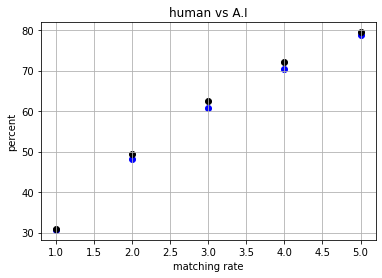

In [73]:
xx,yx = zip(*result_placex.items())
x3,y3 = zip(*human_predict.items())
plt.scatter(xx,yx,color='blue')
plt.scatter(x3,y3,color='black')
plt.title('human vs A.I')
plt.xlabel('matching rate')
plt.ylabel('percent')
plt.grid(True)

In [74]:
tansho_placex = calc_gain(me.calc_test_return, pred_table_placex)

  0%|          | 0/100 [00:00<?, ?it/s]

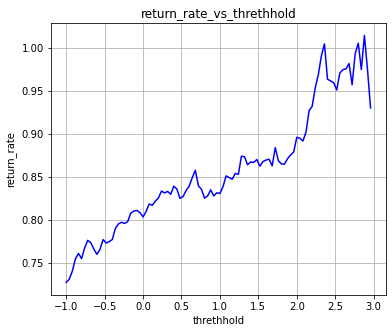

In [75]:
plt.figure(figsize=(6,5))
plt.plot(tansho_placex.index,tansho_placex['return_rate'],color='blue')
plt.title('return_rate_vs_threthhold')
plt.xlabel('threthhold')
plt.ylabel('return_rate')
plt.grid(True)

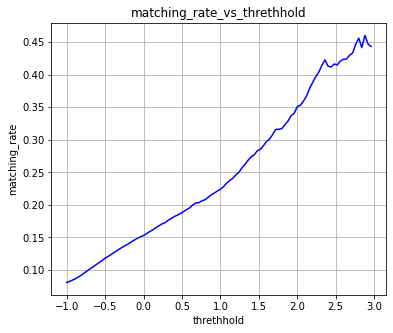

In [76]:
plt.figure(figsize=(6,5))
plt.plot(tansho_placex.index,tansho_placex['n_hits']/tansho_placex['n_bets'],color='blue')
plt.title('matching_rate_vs_threthhold')
plt.xlabel('threthhold')
plt.ylabel('matching_rate')
plt.grid(True)

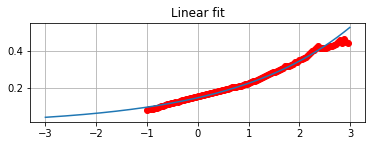

In [77]:
def fit_exp_linear(parameter, x, y):
    a = parameter[0]
    b = parameter[1]
    residual = np.log(y) - (np.log(a) + b * x)
    return residual

def exp_string(a, b):
    return "$y = %0.4f e^{ %0.4f x}$" % (a, b)

if __name__ == "__main__":

    x = tansho_placex.index
    y = tansho_placex['n_hits']/tansho_placex['n_bets']
    
    parameter0 = [1, 1]

    param = sp.optimize.leastsq(fit_exp_linear, parameter0, args=(x, y))

    model_func = lambda a, b, x: a * np.exp(b * x)

    fig = plt.figure()

    ax2 = fig.add_subplot(2, 1, 2)

    ax2.plot(x, y, "ro")

    xx = np.arange(-3, 3, 0.01)

    ax2.plot(xx, model_func(param[0][0], param[0][1], xx))
    ax2.set_title("Linear fit")
    ax2.grid(True)
    plt.show()

In [28]:
del X_test_placex,X_train_placex,X_valid_placex

# Shutuba_data

In [108]:
race1 = '中山'
race2 = '阪神'
race3 = '中京'
raceid1 = '2023060302'
raceid2 = '2023090202'
raceid3 = '2023070206'

sr = 1
race_id1 = [raceid1+'{}'.format(str(i).zfill(2)) for i in range(sr,13,1)]
race_id2 = [raceid2+'{}'.format(str(i).zfill(2)) for i in range(sr,13,1)]
race_id3 = [raceid3+'{}'.format(str(i).zfill(2)) for i in range(sr,13,1)]
race_id_list = race_id1 + race_id2 + race_id3
#race_id_list.remove('202106050909')
st = ShutubaTable.scrape(race_id_list)

  0%|          | 0/36 [00:00<?, ?it/s]

In [109]:
st.data = st.data[st.data['horse_id'] != '2020105222']
#st.data = st.data[st.data['trainer_id'] != '01195']
#st.data = st.data[st.data['jockey_id'] != '05620']

st.preprocessing(weight=True)
st.merge_horse_results(hr,n_samples_list=[1,2,3,4])
st.merge_jockey_results(jr,n_samples_list=[60])
st.merge_trainer_results(tr,n_samples_list=[60])
st.data_p.dropna(subset=['h_rank/heads_1R'],inplace=True)
st.process_categorical(r.data_p,st=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [110]:
df_vs = pd.DataFrame()
df_vs = pd.DataFrame(st.data_c[f_params].add_prefix('vs_')).groupby(level=0).transform(standard_scaler)
st.data_c = pd.concat([st.data_c,df_vs],axis=1)
st.data_c = st.data_c.fillna(r.data_c.median())
pred_table_stx = st.data_c.copy()
predx_1 = pd.DataFrame(network_placex_1.predict(transform_input2(pred_table_stx)),index=pred_table_stx.index).groupby(level=0).transform(standard_scaler)
predx_2 = pd.DataFrame(network_placex_2.predict(transform_input2(pred_table_stx)),index=pred_table_stx.index).groupby(level=0).transform(standard_scaler)
pred_table_stx['pred_nn_art'] = (predx_1*2+predx_2)/3
pred_table_stx['ratio'] = param[0][0] * np.exp(param[0][1] * pred_table_stx['pred_nn_art'])
pred_table_stx['waku_winrate'] = pred_table_stx['waku_winrate']*100
pred_table_stx['style_winrate'] = pred_table_stx['style_winrate']*100
for xxx in ('vs_runtime_3R','vs_spurt_3R','vs_rush_3R','vs_diff_3R','vs_jp_rate_60R'):
    max = r.data_c[xxx].max()
    min = r.data_c[xxx].min()
    pred_table_stx[xxx] = pred_table_stx[xxx].apply(lambda x: 100*(x-min)/(max-min))


In [111]:
show_params = ['number','waku_winrate','horse','days','interval','weight','++weight','vs_runtime_3R','vs_spurt_3R','vs_rush_3R','vs_diff_3R','1st_corner_3R','style_winrate','jockey','jp_rate_60R','popularity','ozz','pred_nn_art','ratio','Ex']

## 中山

In [112]:
R = '12'
show,save = show_ai_index_table(raceid1, R, pred_table_stx, st.data_p, race1, save=True)
ai_index_table_to_dynamo(save)
show[show_params].reset_index().style.background_gradient(cmap='Wistia')

  0%|          | 0/1 [00:00<?, ?it/s]

中山12 芝 1200m
[コース更新]place: 中山, course_id: 06011200
[レース更新]race_date: 2023-03-26, race_id: 202306030212


,index,number,waku_winrate,horse,days,interval,weight,++weight,vs_runtime_3R,vs_spurt_3R,vs_rush_3R,vs_diff_3R,1st_corner_3R,style_winrate,jockey,jp_rate_60R,popularity,ozz,pred_nn_art,ratio,Ex
0,202306030212,5,21.369863,イズンシーラブリー,4.956164,0.493097,426.000000,4.000000,76.067326,83.747154,76.365462,69.460016,14.666667,10.652174,横山武,-0.916291,2,3.700000,1.811363,0.316799,1.172155
1,202306030212,4,21.369863,ブロンズレッド,5.101370,0.723208,526.000000,2.000000,58.716242,56.780606,63.481215,50.306986,10.666667,15.094340,幸,-1.455287,6,14.100000,1.300808,0.254645,3.590491
2,202306030212,10,18.407311,アップリバー,5.101370,2.498356,492.000000,-6.000000,59.767823,53.773540,45.880522,58.761942,3.333333,25.117529,柴田善,-1.897120,5,8.400000,0.642635,0.192160,1.614141
3,202306030212,3,20.762712,スーリールダンジュ,4.024658,0.920447,480.000000,-6.000000,68.706260,60.672362,70.744818,74.417141,11.333333,15.094340,津村,-1.321756,1,3.400000,0.597659,0.188498,0.640893
4,202306030212,2,18.942731,カシノフォワード,4.901370,0.493097,436.000000,0.000000,60.819404,49.477017,49.300019,50.041776,4.000000,25.117529,小林美,-2.484907,8,21.700000,0.500222,0.180803,3.923424
5,202306030212,1,22.826087,ゼンカイテン,3.997260,0.690335,470.000000,-2.000000,32.952511,27.992687,31.939270,36.478028,4.000000,25.117529,原,-1.897120,7,16.700000,0.442786,0.176415,2.946129
6,202306030212,13,16.753247,スマートルシーダ,4.832877,3.944773,464.000000,0.000000,69.757841,57.516309,59.171970,60.210296,7.000000,20.000000,菅原明,-1.386294,4,8.000000,0.063141,0.149971,1.199766
7,202306030212,7,19.571046,ヒノクニ,4.153425,0.493097,448.000000,2.000000,59.767823,62.963696,60.394491,60.231420,8.333333,20.000000,西塚,-2.995732,3,7.400000,-0.099404,0.139897,1.035240
8,202306030212,9,22.148541,ポピュラーソング,5.934247,0.953320,454.000000,10.000000,58.190452,61.206031,56.041571,63.064319,7.000000,20.000000,菊沢,-2.014903,12,45.100000,-0.655277,0.110291,4.974146
9,202306030212,11,18.407311,アレクサンドラ,3.893151,0.493097,504.000000,4.000000,31.900930,36.520513,39.823637,36.169859,7.333333,20.000000,江田照,-1.897120,10,32.300000,-0.928811,0.098113,3.169046


## 阪神

In [113]:
#R = '09'
show, save = show_ai_index_table(raceid2, R, pred_table_stx, st.data_p, race2, save=True)
ai_index_table_to_dynamo(save)
show[show_params].reset_index().style.background_gradient(cmap='Wistia')

  0%|          | 0/1 [00:00<?, ?it/s]

阪神12 ダート 1200m
[コース更新]place: 阪神, course_id: 09001200
[レース更新]race_date: 2023-03-26, race_id: 202309020212


,index,number,waku_winrate,horse,days,interval,weight,++weight,vs_runtime_3R,vs_spurt_3R,vs_rush_3R,vs_diff_3R,1st_corner_3R,style_winrate,jockey,jp_rate_60R,popularity,ozz,pred_nn_art,ratio,Ex
0,202309020212,15,24.047124,ゼットノヴァ,3.901370,0.920447,442.000000,0.000000,59.978144,80.289729,80.501757,80.737056,10.000000,14.139344,高倉,-1.897120,2,4.000000,2.195988,0.373454,1.493816
1,202309020212,12,20.396601,サトノテンペスト,4.961644,3.484550,508.000000,2.000000,83.511643,68.644409,54.003072,72.981496,3.000000,24.879808,Ｍデムーロ,-1.149906,1,2.700000,1.741405,0.307459,0.830139
2,202309020212,9,20.590353,カフジエニアゴン,4.049315,0.460224,500.000000,2.000000,82.204226,36.672016,45.038720,63.546447,1.000000,25.979217,北村友,-1.696449,3,4.400000,1.431662,0.269305,1.184941
3,202309020212,5,19.726859,ロードミッドナイト,5.093151,2.071006,530.000000,-6.000000,61.285561,49.370436,44.516214,58.829313,3.000000,24.879808,菱田,-1.386294,4,9.000000,0.716666,0.198342,1.785081
4,202309020212,16,24.047124,ヒルノショパン,3.945205,1.150559,444.000000,-2.000000,52.133645,40.424907,36.562247,36.232842,3.666667,24.879808,今村,-1.529395,6,21.300000,0.244874,0.162094,3.452611
5,202309020212,1,16.102395,マルモリスペシャル,3.854795,5.292571,538.000000,12.000000,50.826228,46.073962,45.808524,58.281378,3.666667,24.879808,泉谷,-1.455287,5,14.500000,-0.086148,0.140693,2.040047
6,202309020212,7,20.177384,ドンフクリン,3.835616,1.873767,464.000000,2.000000,61.285561,57.108660,55.227771,56.147676,6.000000,18.841262,小沢,-2.484907,12,56.400000,-0.146794,0.137090,7.731875
7,202309020212,14,19.636618,ゴールドフィンガー,4.967123,3.221565,462.000000,-4.000000,63.900394,61.318034,65.537227,59.391725,11.000000,14.139344,水口,-1.609438,10,53.000000,-0.281409,0.129419,6.859199
8,202309020212,4,19.984448,デルマカンノン,5.030137,1.150559,444.000000,-2.000000,46.903978,57.162928,62.399076,47.714914,9.666667,14.139344,松若,-1.696449,11,54.700000,-0.409530,0.122517,6.701670
9,202309020212,2,16.102395,ミラクル,4.871233,1.413544,470.000000,2.000000,58.670728,70.102461,52.701659,51.064485,7.333333,18.841262,酒井,-2.302585,7,22.100000,-0.619874,0.111974,2.474635


## 中京

In [114]:
R = '08'
show, save = show_ai_index_table(raceid3, R, pred_table_stx, st.data_p, race3, save=True)
ai_index_table_to_dynamo(save)
show[show_params].reset_index().style.background_gradient(cmap='Wistia')

  0%|          | 0/1 [00:00<?, ?it/s]

中京12 ダート 1400m
[コース更新]place: 中京, course_id: 07001400
[レース更新]race_date: 2023-03-26, race_id: 202307020612


,index,number,waku_winrate,horse,days,interval,weight,++weight,vs_runtime_3R,vs_spurt_3R,vs_rush_3R,vs_diff_3R,1st_corner_3R,style_winrate,jockey,jp_rate_60R,popularity,ozz,pred_nn_art,ratio,Ex
0,202307020612,11,20.247569,コンクエスト,3.893151,0.460224,488.000000,-6.000000,64.227129,62.903455,71.817758,70.218411,3.666667,24.043716,戸崎圭,-1.149906,2,5.500000,1.626446,0.292705,1.609878
1,202307020612,6,20.217588,エーティーマクフィ,3.890411,3.254438,468.000000,-4.000000,72.038685,63.687854,74.355639,71.695295,5.666667,24.043716,松山,-0.836248,1,2.900000,1.569463,0.285657,0.828404
2,202307020612,15,19.860017,エルバリオ,4.065753,0.920447,524.000000,-2.000000,67.481944,55.306441,62.293226,69.470548,3.333333,24.043716,鮫島駿,-1.098612,3,6.000000,0.884921,0.213144,1.278864
3,202307020612,12,19.507909,リファインドマナー,5.112329,1.873767,446.000000,-8.000000,59.670389,60.494703,44.538225,55.019522,2.666667,26.899128,松本,-2.148434,12,36.300000,0.767016,0.202661,7.356578
4,202307020612,13,19.507909,ゼットレヨン,4.002740,1.840894,482.000000,0.000000,66.830981,38.654948,52.962754,43.824603,5.333333,24.043716,川須,-2.302585,9,23.200000,0.733413,0.199768,4.634625
5,202307020612,2,18.346008,ワンダースティング,5.123288,2.498356,510.000000,-4.000000,62.274241,48.335572,60.387591,55.758250,5.333333,24.043716,和田竜,-2.148434,5,10.500000,0.548728,0.184594,1.938233
6,202307020612,10,20.247569,タガノペカ,5.013699,2.564103,508.000000,-4.000000,55.764611,55.183067,48.288362,55.078200,6.333333,20.101899,国分恭,-2.148434,4,9.600000,0.146807,0.155435,1.492178
7,202307020612,5,20.876048,ミレヴィーナス,4.000000,4.865220,434.000000,-8.000000,58.368463,55.071250,68.041638,75.276798,2.000000,26.899128,岩田望,-0.958850,7,13.800000,0.038558,0.148402,2.047946
8,202307020612,4,20.876048,ハクサンライラック,6.978082,0.493097,506.000000,-2.000000,72.689648,87.678536,67.830856,56.543675,9.666667,14.867366,団野,-1.696449,6,12.400000,-0.042277,0.143358,1.777641
9,202307020612,7,20.217588,ケルンコンサート,3.972603,1.183432,464.000000,0.000000,29.075129,21.873220,26.329566,32.371398,3.666667,24.043716,岩田康,-1.529395,10,31.400000,-0.833535,0.102194,3.208895


# practice

In [194]:
df = pd.read_pickle('race_card_tables.pickle')
df

,date,R,race_name,race_genre,race_grade,発走時刻,馬番,枠,horse_id,馬名,性齢,斤量,jockey_id,騎手,course_id,place,course_len,R_type
202307020510,2023-03-25,10R,熊野特別,サラ系４歳以上,２勝クラス,14:50,1,1,2019105312,ワープスピード,牡4,57.0,00732,幸,07012200,中京,2200,芝
202307020510,2023-03-25,10R,熊野特別,サラ系４歳以上,２勝クラス,14:50,2,2,2018104512,エルディアブロ,牡5,58.0,01154,松若,07012200,中京,2200,芝
202307020510,2023-03-25,10R,熊野特別,サラ系４歳以上,２勝クラス,14:50,3,3,2018103507,イヤサカ,牝5,56.0,01034,酒井,07012200,中京,2200,芝
202307020510,2023-03-25,10R,熊野特別,サラ系４歳以上,２勝クラス,14:50,4,4,2019100808,ブルーゲート,牝4,55.0,01197,佐々木,07012200,中京,2200,芝
202307020510,2023-03-25,10R,熊野特別,サラ系４歳以上,２勝クラス,14:50,5,4,2016100126,ダディーズトリップ,牡7,58.0,01127,丸山,07012200,中京,2200,芝
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202306030207,2023-03-26,7R,4歳以上1勝クラス,サラ系４歳以上,１勝クラス,13:15,8,6,2019102648,エスティメート,牡4,58.0,01135,杉原,06001800,中山,1800,ダート
202306030207,2023-03-26,7R,4歳以上1勝クラス,サラ系４歳以上,１勝クラス,13:15,9,7,2019103021,ロードブライト,牡4,57.0,01188,永野,06001800,中山,1800,ダート
202306030207,2023-03-26,7R,4歳以上1勝クラス,サラ系４歳以上,１勝クラス,13:15,10,7,2019103671,デライトアゲン,牡4,58.0,01162,木幡巧,06001800,中山,1800,ダート
202306030207,2023-03-26,7R,4歳以上1勝クラス,サラ系４歳以上,１勝クラス,13:15,11,8,2018104517,フロンタルクリス,牡5,58.0,01161,菊沢,06001800,中山,1800,ダート


In [108]:
df =  pd.read_pickle('ai_index_table_202310020609')
df

,date,ground,weather,course_id,number,waku,waku_winrate,horse_id,days,weight,++weight,interval,vs_runtime_3R,vs_spurt_3R,vs_rush_3R,vs_diff_3R,1st_corner_3R,style_winrate,jockey_id,jp_rate_60R,ozz,popularity,ratio
202310020609,2023-02-26,良,晴,09011800,1,1,24.693252,2019105208,3.956164,502.0,-16.0,0.920447,21.546695,15.232808,17.290785,26.635668,3.000000,25.557103,01186,-1.529395,43.3,12,0.097445
202310020609,2023-02-26,良,晴,09011800,2,2,23.252496,2019100702,3.942466,482.0,6.0,0.953320,55.941488,55.967970,61.868281,58.976253,11.000000,17.618271,01091,-1.386294,16.4,8,0.144197
202310020609,2023-02-26,良,晴,09011800,3,2,23.252496,2017106366,6.043836,530.0,6.0,3.484550,67.708128,42.642483,53.280971,49.767691,9.666667,17.618271,01168,-1.897120,21.7,10,0.104819
202310020609,2023-02-26,良,晴,09011800,4,3,19.891746,2018105327,4.909589,478.0,-8.0,0.920447,56.846614,36.247349,38.119176,46.184705,7.333333,23.024269,01093,-1.098612,18.0,9,0.124681
202310020609,2023-02-26,良,晴,09011800,5,3,19.891746,2019106596,3.860274,504.0,-4.0,0.262985,81.285020,66.339947,74.280202,78.066370,9.000000,17.618271,01182,-1.386294,13.6,6,0.272796
202310020609,2023-02-26,良,晴,09011800,6,4,20.801034,2017106399,5.980822,432.0,-4.0,0.230112,55.941488,47.387304,43.102515,38.955350,9.333333,17.618271,01015,-1.791759,101.3,14,0.088440
202310020609,2023-02-26,良,晴,09011800,7,4,20.801034,2019102384,4.024658,468.0,-4.0,0.493097,40.554344,63.461446,52.518911,53.485577,9.000000,17.618271,01144,-1.386294,6.3,4,0.205024
202310020609,2023-02-26,良,晴,09011800,8,5,22.512438,2017105179,5.827397,446.0,8.0,3.451677,60.467119,60.710932,60.865520,60.884995,8.000000,23.024269,01171,-1.049822,3.8,1,0.212580
202310020609,2023-02-26,良,晴,09011800,9,5,22.512438,2019101743,3.934247,460.0,2.0,0.723208,61.372245,72.487953,60.919446,60.646193,9.333333,17.618271,01185,-2.302585,56.8,13,0.116824
202310020609,2023-02-26,良,晴,09011800,10,6,22.569028,2017105614,6.120548,460.0,0.0,0.262985,52.320984,53.347888,58.628882,53.705974,8.333333,23.024269,01116,-1.321756,16.1,7,0.164125


# analyze

In [122]:
df =  pd.read_pickle('race_card_tables.pickle')
df.loc['202309020104']#
.dtypes
#df['course_len'].sort_values().unique()

,date,R,race_name,race_genre,race_grade,発走時刻,馬番,枠,horse_id,馬名,性齢,斤量,jockey_id,騎手,course_id,place,course_len,R_type
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,10,7,2018103204,ヤマノグリッターズ,牡5,60.0,01068,蓑島,09003110,阪神,3110,ダート
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,5,4,2018102170,マイネルグロン,牡5,60.0,01069,五十嵐,09003110,阪神,3110,ダート
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,6,5,2017105445,ビーマイオーシャン,牡6,58.0,01196,小牧加,09003110,阪神,3110,ダート
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,7,5,2018106172,ウインガヴァナー,牡5,60.0,00652,熊沢,09003110,阪神,3110,ダート
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,8,6,2016105167,ゴールドフレーム,セ7,60.0,01087,上野,09003110,阪神,3110,ダート
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,12,8,2018100752,タンジェントアーク,牡5,60.0,01120,大江原,09003110,阪神,3110,ダート
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,9,6,2018105731,メイショウアツイタ,牡5,60.0,01066,難波,09003110,阪神,3110,ダート
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,11,7,2017104706,オメガエリタージュ,セ6,60.0,01139,森一,09003110,阪神,3110,ダート
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,1,1,2018106129,アレデラヴァン,セ5,60.0,01149,伴,09003110,阪神,3110,ダート
202309020104,2023-03-25,4R,4歳以上障害OP,障害４歳以上,オープン,11:30,2,2,2018104525,ポルタフォリオ,牡5,60.0,00691,北沢,09003110,阪神,3110,ダート


In [123]:
df =  pd.read_pickle('waku_winrate.pickle')
df
#df[df['place']=='09']

着順  waku_winrate
place R_type course_len waku                        
1     ダート    1000.0     1     0.212291      0.212291
                        2     0.191011      0.191011
                        3     0.248588      0.248588
                        4     0.296089      0.296089
                        5     0.291793      0.291793
...                                ...           ...
10    障害     3390.0     4     0.290323      0.290323
                        5     0.250000      0.250000
                        6     0.325581      0.325581
                        7     0.300000      0.300000
                        8     0.139535      0.139535

[1135 rows x 2 columns]

df = r.data_c[delete_list].copy()
df.head(5)

In [182]:
race_id = '202306020311'
url = 'https://race.netkeiba.com/race/result.html?race_id=' + race_id
df = pd.read_html(url)[0]
df

ValueError: Expected a 1D array, got an array with shape (16, 15)